<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 12 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 1 April 2024</div>

# Generalized Linear Models

With the Red Sox, we saw how we can add parameters to our models to study categories such as player positions not directly apparent (i.e. hidden or latent) in observation data, using *hierarchical modeling*:
```
with pm.Model() as double_hierarchy_model:
    a = pm.Beta('a', 1., 1.)
    b = pm.Gamma('b', 0.01, 0.01)
    alpha = pm.Beta('alpha', a, b, shape = num_positions)
    beta = pm.Gamma('beta', 0.1, 0.1, shape = num_positions)
    theta = pm.Beta('theta', alpha[position_idx], beta[position_idx]), shape = num_players)
    y = pm.Binomial('y', n=df['AtBats'], p=theta, observed=df['Hits'])
```
Hierarchical modeling allow us to group players into categories, be it *real* categories (as in player positions), or *latent* categories (categories we think are a principal cause to an effect, as in an attacking team component and a defensive team component):

> **Sidenote**: We saw how to decompose a team into an batting and pitching strengths by separetely modeling points scored and points opponents scored as a Poisson with expectation $\theta$ where we model $\theta$ as log-additive model:
$$\log(θ_1) = \text{home} + \text{att}_g + \text{def}_g \\
\log(θ_2) = \text{att}_g + \text{def}_g$$
We can then predict who's likely to win the season by sampling from the posterior predictive.

Hierarchical modeling allow you the data scientist to build more *refined* models, aided with simulation power.

>**Sidenote**: You've already been doing similar modeling. For example, if you take our MLB data, you could easily compute an average hitting performance for the MLB, an average hitting performance for each player, and an average hitting performnace for player positions, right?

> What we did is not too different, we just got *distributions* instead of *point values*! Distributions contain a lot more knowledge than point values, because they also tell us how *sure* we are of our average, just by looking at how dispered or tight the distribution is.

But how can we *compare* the contribution of one *latent* (hidden) factor versus another, to better manage a team? 

For example, is it more important to hire a new pitcher, or to hire *three* new batters? Obviously, this is only possible when we have *data* aboout each parameter. So, this notebook, dedicated to the other fabled Boston franchise, *the Celtics*, attempts to model team performance with bayesian statistics!

<br />
<center>
<img src="ipynb.images/CelticsWordmark.png" width=1000 />
</center>

The method we're going to explore is called **Bayesian linear regression**, and the easiest way to implement it is using [patsy formulas](https://patsy.readthedocs.io/en/latest/formulas.html) and [Generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model).

## 1. Two-factor binomial likelihood
Let's generate artificial data and attribute results to *two* latent factors that we wish to measure.

In statistics, the [logistic model](https://en.wikipedia.org/wiki/Logistic_regression) (or logit model) is a statistical model that models the probability of an event taking place by having the *probabilities* for the event be a linear combination of one or more independent variables.

Formally, in binary logistic regression there is a single binary dependent variable, where the two values are labeled `0` and `1`, while the independent variables can also be a binary variable (two classes) or be a continuous variable (any real value). 

The corresponding probability of the value can vary between 0 (certainly the value `0`) and 1 (certainly the value `1`).

The function that converts log-odds to probability is the **logistic function**.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy.special import expit

*Bernoulli regression* is useful when your outcome variable is a success or a fail, that is, `0` or `1` observations. An example of this kind of outcome variable is *did MV win his race today?* 

*Binomial regression* is useful when you have a certain number of successes out of $n$ trials. So the example would be, *how many wins for MV in the last 7 days?*

The observed data (e.g. $1,0,1,1,0,1,1,1,0,0,\cdots$) are a set of counts of number of successes out of total trials. 
 
Many people might be tempted to reduce this data to a proportion, but this is not necessarily a good idea. For example, proportions are not directly measured, they are often best treated as latent variables to be estimated. Also, a proportion looses information: a proportion of 0.5 could respond to 1 run out of 2 days, or to 4 runs in the last 4 weeks, or many other things, but you have lost that information by paying attention to the proportion alone.

The appropriate likelihood for binomial regression is the **binomial distribution**:

$$y_i = \text{binomial}(n, p_i)$$

where $y_i$ is a count of the number of successes out of $n$ trials, and $p_i$ is the (latent) probability of success. 

What we want to achieve with binomial regression is to use a linear model to accurately estimate $p_i = \beta_0 + \beta_1x_i$, the winning probability, which depends on two factors $\beta_0$ and $\beta_1$. 

Specifically, we want to measure $\beta_0$ and $\beta_1$. Think of each factor $\beta$ representing a different effect. 

For example, $\beta_0$ could represent how much sleep MV had the night before a race, and $\beta_1$ could represent how good the new Honda block engine is. These effecst are *latent* because they could definitely contribute to a win or a loss, but they are *hidden*: Only MV wins, not his engine or the amount of sleep he had the night before his race.

In our last MLB notebook, we used an **additive model** where we assumed that how well a team does is a mixed result of two effects: the pitchers and the batters, but we did not try to measure one versus the other because we do not have independent data about one parameter versus the other, so it would have been impossible to objectively compare them. All we were able to compare are pitching distributions between teams (defense), and batting distributions between teams (attack).

Today, we are actually going to try to compare $\beta_0$ with $\beta_1$.

So we could do this with a likelihood pdf like so:

$$y_i = \text{binomial}(n, \beta_0 + \beta_1x_i)$$

where

$$ p_i = \beta_0 + \beta_1x_i$$

If we did this though, we would quickly run into problems when the linear model generates values of $p_i$ outside the range of $[0, 1]$. 

This is where a **link function** $g$ comes into play:

$$g(p_i) = \beta_0 + \beta_1x_i$$

$g$ can be thought of as a transformation that maps proportions in the range $[0, 1]$ to the domain $(-\infty, +\infty)$. There are a number of potential functions that could be used, but a common one to use is the [logit function](https://en.wikipedia.org/wiki/Logit).

But what we actually want to do is to rearrange this equation for $p_i$, so that we can enter it into the likelihood function:

$$p_i = g^{-1}(\beta_0 + \beta_1x_i)$$

where $g^{-1}$ is the inverse of the link function, in this case the inverse of the logit function: The [logistic sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), also known as the `expit` function). So if we enter this into our likelihood function we end up with:

$$y_i = \text{binomial}(n, \, \text{expit}(\beta_0 + \beta_1x_i))$$

This defines our likelihood function. All we need now for a Bayesian Binomial regression are priors over the 
$\beta$ parameters. The observed data are $y_i$, $n$, and $x_i$ (we will generate that).

## Building our dataset
So, let's *cheat* and set some values for $\beta_0$ and $\beta_1$, generate some data, add some noise, and then try to run an mcmc simulation to recover the most likely values of $\beta_0$ and $\beta_1$ (yes, professors all over the world are *allowed* to do that :-)

In [2]:
# true params, set and forget
beta0_true = 0.7
beta1_true = 0.4

# number of wins/losses
n = 20

sample_size = 30
x = np.linspace(-10, 20, sample_size)

# Linear model
mu_true = beta0_true + beta1_true * x

# transformation (inverse logit function = expit)
p_true = expit(mu_true)

# Generate data WITH NOISE
rng = np.random.default_rng(1234)
y = rng.binomial(n, p_true)

# bundle data into dataframe
data = pd.DataFrame({"x": x, "y": y})
data

,x,y
0,-10.000000,3
1,-8.965517,1
2,-7.931034,3
3,-6.896552,1
4,-5.862069,2
5,-4.827586,2
6,-3.793103,5
7,-2.758621,7
8,-1.724138,6
9,-0.689655,13


Let's plot the underlying linear model and the noisy binomial model:

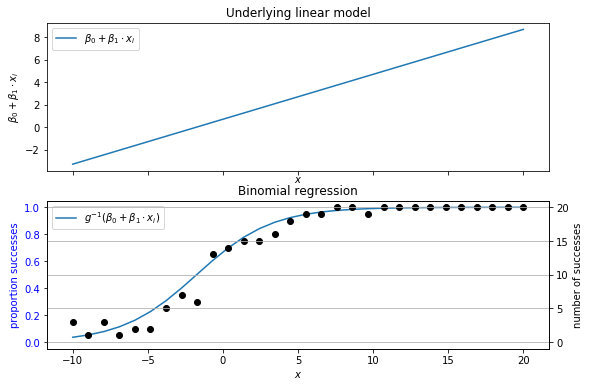

In [3]:
# Plot underlying linear model
fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
ax[0].plot(x, mu_true, label=r"$β_0 + β_1 \cdot x_i$")
ax[0].set(xlabel="$x$", ylabel=r"$β_0 + β_1 \cdot x_i$", title="Underlying linear model")
ax[0].legend()

# Plot GLM
freq = ax[1].twinx()  # instantiate a second axes that shares the same x-axis
freq.set_ylabel("number of successes")
freq.scatter(x, y, color="k")
# plot proportion related stuff on ax[1]
ax[1].plot(x, p_true, label=r"$g^{-1}(β_0 + β_1 \cdot x_i)$")
ax[1].set_ylabel("proportion successes", color="b")
ax[1].tick_params(axis="y", labelcolor="b")
ax[1].set(xlabel="$x$", title="Binomial regression")
ax[1].legend()
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[1].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)

The top figure shows the (untransformed) linear model. We can see that the linear model is generating values outside the range 
$[0,1]$, making clear the need for an inverse link function $g^{-1}$, which converts from the domain of $(-\infty, +\infty)$ to $[0,1]$. As we’ve seen, this is done by the inverse logistic function (aka logistic sigmoid).

## Building our Model
Let's build our data likelihood pdf and model its `p` parameter as the inverse logit of a `mu` that is a linear regression of $\beta_0$ and $\beta_1$. 

We then model these two parameters with Normal pdfs in order to sample their most likely value using an mcmc simulation.

In [4]:
coords = {"observation": data.index.values}

with pm.Model() as binomial_regression_model:
    x = pm.Data("x", data["x"])
    
    # priors
    beta0 = pm.Normal("beta0", mu=0, sd=1)
    beta1 = pm.Normal("beta1", mu=0, sd=1)
    
    # linear model
    mu = beta0 + beta1 * x
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    
    # likelihood
    pm.Binomial("y", n=n, p=p, observed=data["y"])

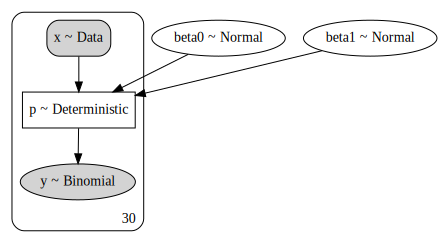

In [5]:
pm.model_to_graphviz(binomial_regression_model)

Let's simulate:

In [6]:
with binomial_regression_model:
    idata = pm.sample(1000, tune=2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta1, beta0]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:02<00:00, 1258.75it/s]


Let's plot results:

d:\Anaconda3.5.1\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


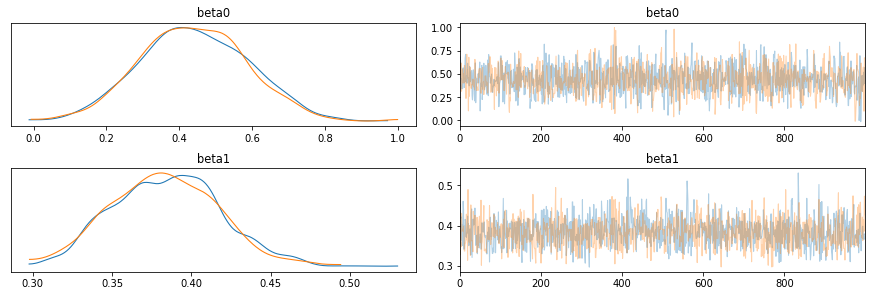

In [7]:
az.plot_trace(idata, var_names=["beta0", "beta1"]);

I don't plot the `p` parameter because we have over 20 of them, one for each value of `x`.

## Analyzing results
Let's plot our model predictions in data space and our posterior beliefs in parameter space.

In [9]:
idata['p'].shape

(2000, 30)

In [104]:
# pymc
#np.array(idata.posterior['p'])

# pymc3
idata['p']

array([[0.01852804, 0.02770822, 0.0412458 , ..., 0.99921571, 0.99948033,
        0.99965569],
       [0.0282362 , 0.04305927, 0.06514231, ..., 0.99974392, 0.99983462,
        0.9998932 ],
       [0.03652386, 0.05397912, 0.0790917 , ..., 0.99957717, 0.99971904,
        0.99981332],
       ...,
       [0.03280808, 0.04939905, 0.07374035, ..., 0.99970651, 0.9998084 ,
        0.99987493],
       [0.03280808, 0.04939905, 0.07374035, ..., 0.99970651, 0.9998084 ,
        0.99987493],
       [0.02037742, 0.0319745 , 0.0498359 , ..., 0.99981823, 0.99988552,
        0.9999279 ]])

In [11]:
idata['p'].mean(axis=0)

array([0.033422  , 0.0485408 , 0.07006703, 0.10022626, 0.14152185,
       0.19629553, 0.26591708, 0.34971377, 0.44412547, 0.54283634,
       0.63826718, 0.72380041, 0.79544742, 0.8521731 , 0.89513885,
       0.92661868, 0.949135  , 0.96496988, 0.9759773 , 0.98356949,
       0.98877945, 0.99234318, 0.9947762 , 0.99643558, 0.99756688,
       0.99833818, 0.99886419, 0.99922312, 0.99946818, 0.99963564])

In [12]:
idata['beta0']

array([0.67227373, 0.82431541, 0.25420815, ..., 0.61091124, 0.61091124,
       0.32072926])

In [13]:
idata['beta1']

array([0.36718783, 0.40294966, 0.41285695, ..., 0.38962105, 0.38962105,
       0.37693333])

In [8]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

d:\Anaconda3.5.1\lib\site-packages\arviz\stats\stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
C:\Users\Dino\AppData\Roaming\Python\Python36\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Dino\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


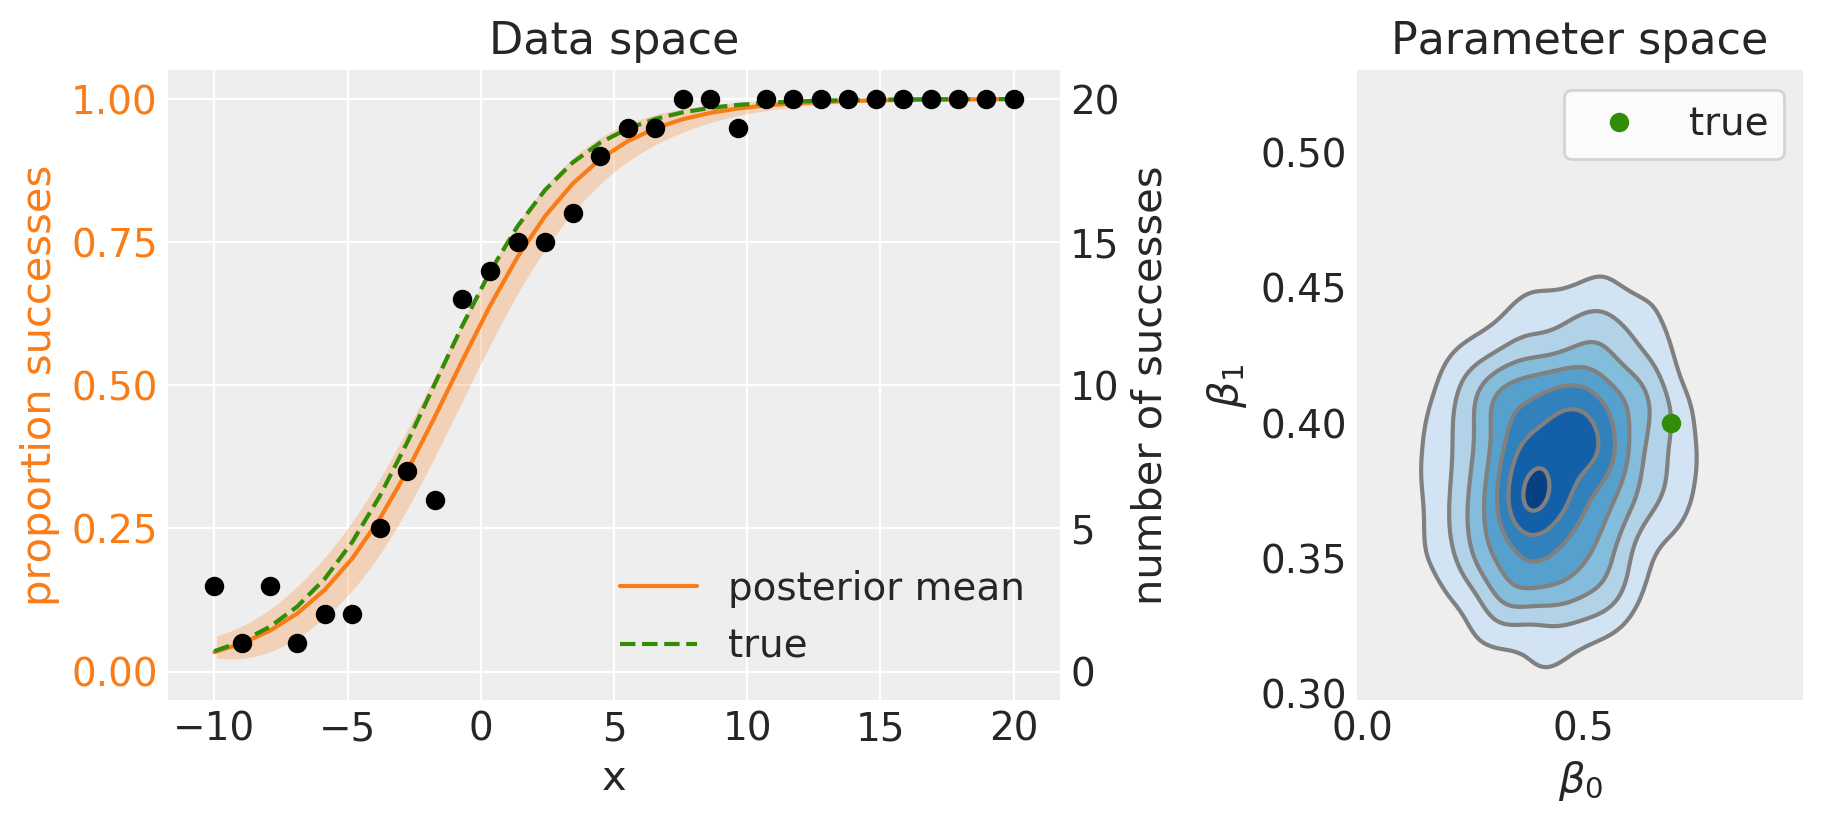

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    idata.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)

# posterior mean
#post_mean = idata.p.mean(("chain", "draw"))
post_mean = idata['p'].mean(axis=0)
ax[0].plot(data["x"], post_mean, label="posterior mean", color="C1")

# plot truth
ax[0].plot(data["x"], p_true, "--", label="true", color="C2")

# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()

# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of successes")
freq.scatter(data["x"], data["y"], color="k", label="data")

# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)

# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, 20, 5) / n)
freq.set(yticks=np.linspace(0, 20, 5))

# Parameter space plot ===================================================
az.plot_kde(
    idata.beta0,
    idata.beta1,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);

The left panel shows the posterior mean as an orange solid line and 95% hdi credible interval (shaded region). Because we are working with simulated data, we know what the true model is (dotted green), so we can see that the posterior mean compares favourably with the true data generating model.

This is also shown by the posterior distribution over parameter space (right panel), which does well when comparing to the true data generating parameters: Our true values of $\beta_0$ and $\beta_1$ (in green) are within credible regions (albeit not a bull's eye!).

Using binomial regression in real data analysis situations would probably involve more predictor variables, and correspondingly more model parameters, but I would say that our simulation uncovered the most likely value of our latent parameters, *from the observable data*.

<center>
<img src="ipynb.images/happy-cat.gif" width=300 />
</center>

## 2. Two-factor Bernoulli likelihood
Instead of a binomial data likelihood that measures number of successes in $n$ trials, we can *also* work with a Bernoulli data likelihood that explodes the number of observations into win/loss use cases.

Bernoulli deals with the outcome of a *single trial* of the event, whereas Binomial deals with the outcome of *multiple trials* of the single event.

A Bernoulli distribution is a special case of binomial distribution. Specifically, when $n=1$, the binomial distribution becomes a Bernoulli distribution.

Say we represent the outcome of the five coin tosses as a list, and three of those tosses must be heads. So we can have
```
{H,H,H,T,T},
{H,H,T,H,T},
{H,H,T,T,H},
{H,T,H,H,T},
{H,T,H,T,H},
{H,T,T,H,H},
{T,H,H,H,T},
{T,H,H,T,H},
{T,H,T,H,H},
{T,T,H,H,H}.
```
As you can see, there are (3 choose 5) = 10 ways to pick the positions of three heads among the five tosses, and for each of these outcomes, the probability of observing three heads is $p^3$ and two tails is $(1−p)^2$.

The binomial distribution looks at 10 total events, whereas the Bernoulli distribution looks at 50 total events.

Let's rewrite our simulation above with a Bernoulli instead of a binomial!

We need to regenerate our `y`s, which now need to be either `0` or `1`:

In [13]:
# true params
beta0_true = 0.7
beta1_true = 0.4

sample_size = 30 * 20
x = np.linspace(-10, 20, sample_size)

# Linear model
mu_true = beta0_true + beta1_true * x

# transformation (inverse logit function = expit)
p_true = expit(mu_true)

# Generate data
rng = np.random.default_rng(1234)
y = rng.binomial(1, p_true)

# bundle data into dataframe
data = pd.DataFrame({"x": x, "y": y})
data

,x,y
0,-10.000000,1
1,-9.949917,0
2,-9.899833,0
3,-9.849750,0
4,-9.799666,0
...,...,...
595,19.799666,1
596,19.849750,1
597,19.899833,1
598,19.949917,1


In [14]:
coords = {"observation": data.index.values}

with pm.Model() as bernoulli_regression_model:
    x = pm.Data("x", data["x"])
    
    # priors
    beta0 = pm.Normal("beta0", mu=0, sd=1)
    beta1 = pm.Normal("beta1", mu=0, sd=1)
    
    # linear model
    mu = beta0 + beta1 * x
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    
    # likelihood
    pm.Bernoulli("y", p=p, observed=data["y"])

In [15]:
with bernoulli_regression_model:
    jdata = pm.sample(1000, tune=2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta1, beta0]
Sampling chain 1, 0 divergences:  26%|██▌       | 783/3000 [02:56<08:20,  4.43it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


d:\Anaconda3.5.1\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


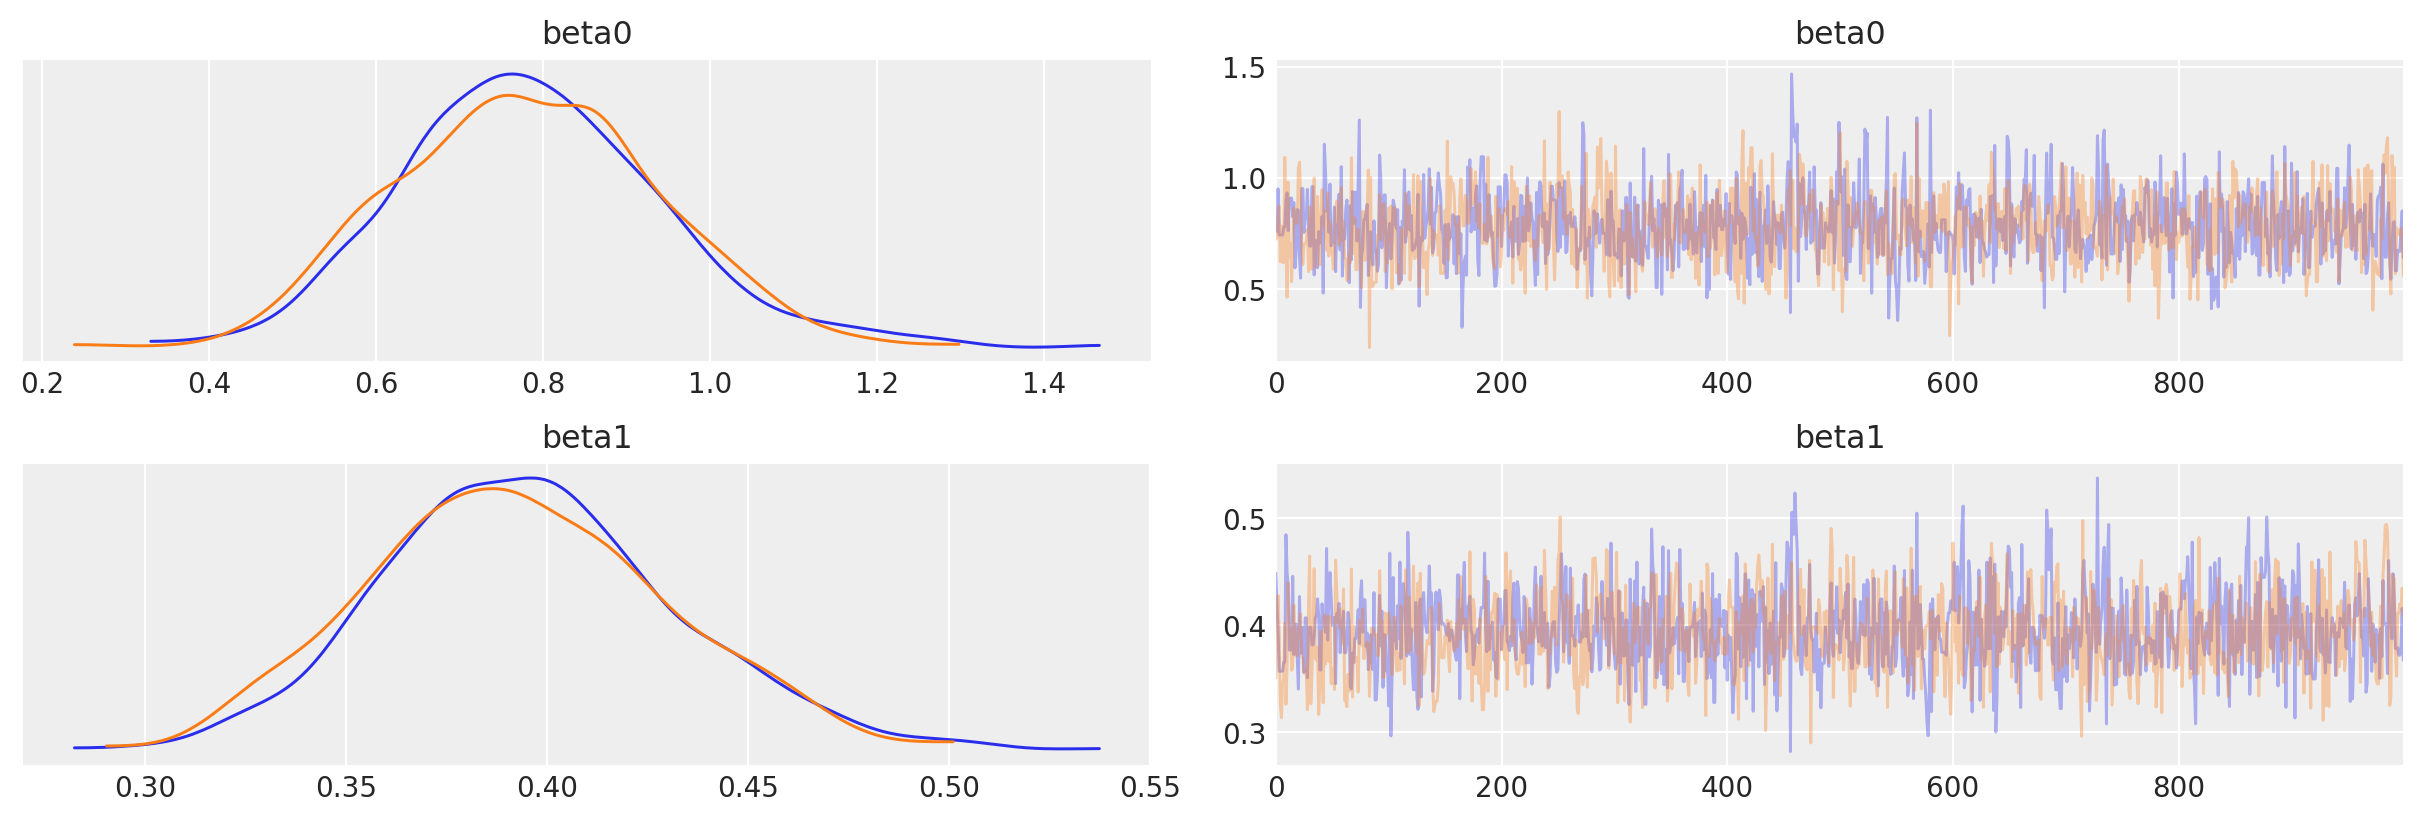

In [110]:
az.plot_trace(jdata, var_names=["beta0", "beta1"]);

In [23]:
jdata['p'].shape

(2000, 600)

In [24]:
jdata['p'].mean(axis=0).shape

(600,)

### Data space plot

d:\Anaconda3.5.1\lib\site-packages\arviz\stats\stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
C:\Users\Dino\AppData\Roaming\Python\Python36\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Dino\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


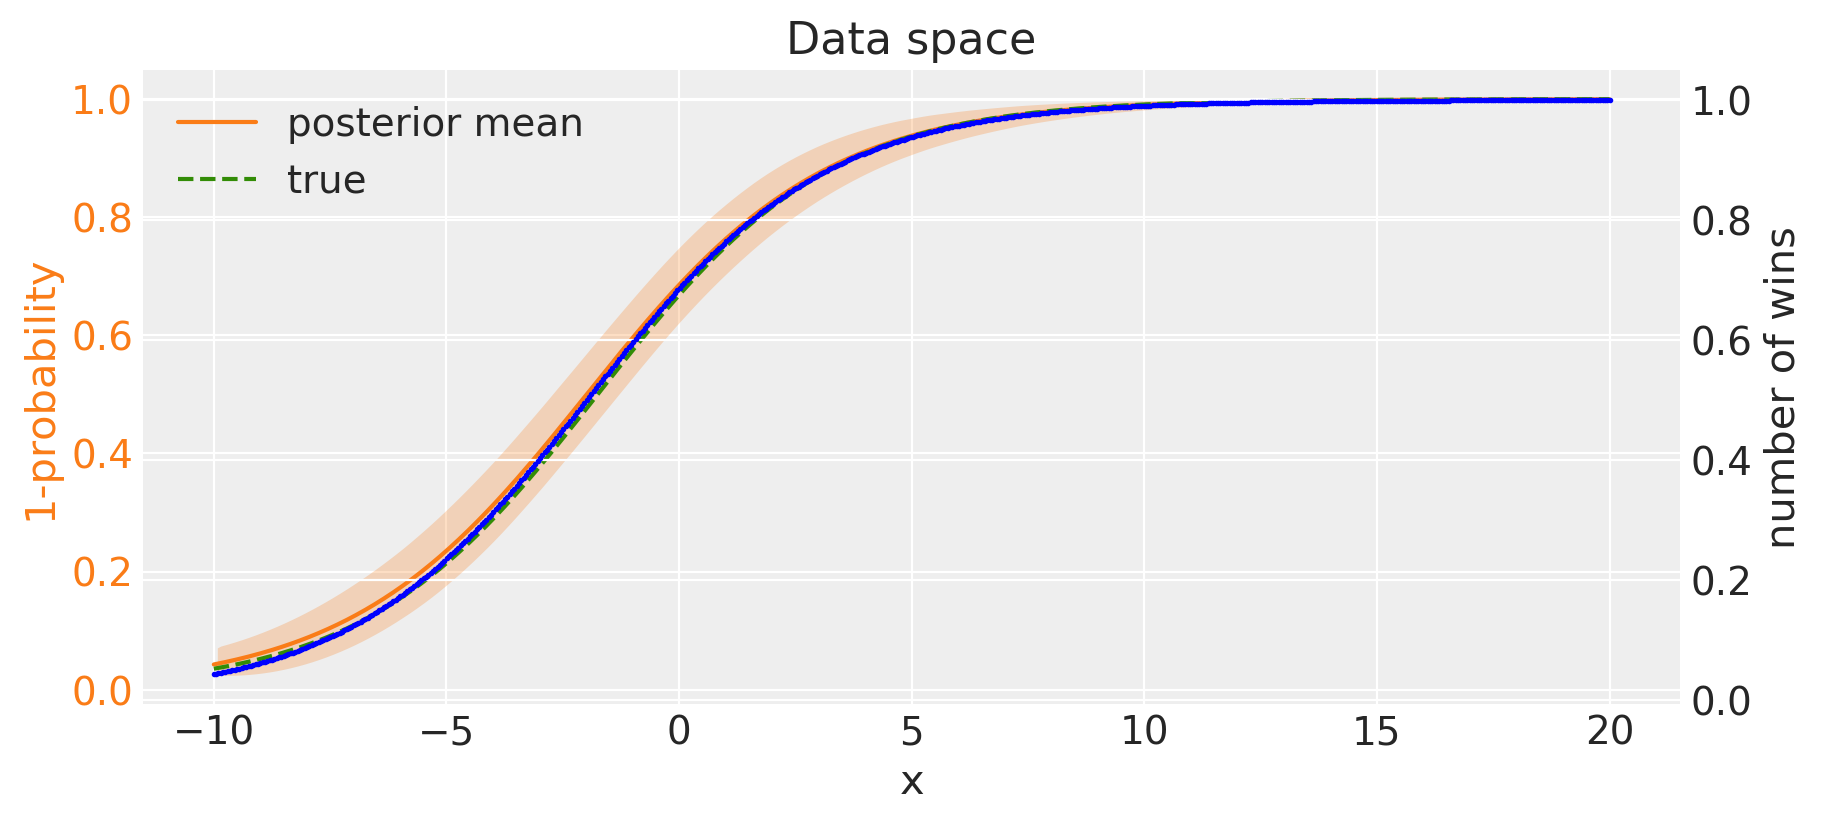

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4), gridspec_kw={"width_ratios": [1]})

az.plot_hdi(
    data["x"],
    jdata.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax,
    color="C1",
)

# posterior mean
#post_mean = idata.p.mean(("chain", "draw"))
post_mean = jdata['p'].mean(axis=0)
ax.plot(data["x"], post_mean, label="posterior mean", color="C1")

# plot truth
ax.plot(data["x"], p_true, "--", label="true", color="C2")

# formatting
ax.set(xlabel="x", title="Data space")
ax.set_ylabel("1-probability", color="C1")
ax.tick_params(axis="y", labelcolor="C1")
ax.legend()

# instantiate a second axes that shares the same x-axis
freq = ax.twinx()
freq.set_ylabel("number of wins")
freq.scatter(data["x"], jdata['p'].mean(axis=0), color="b", label="data", s=1)

### Parameter space plot

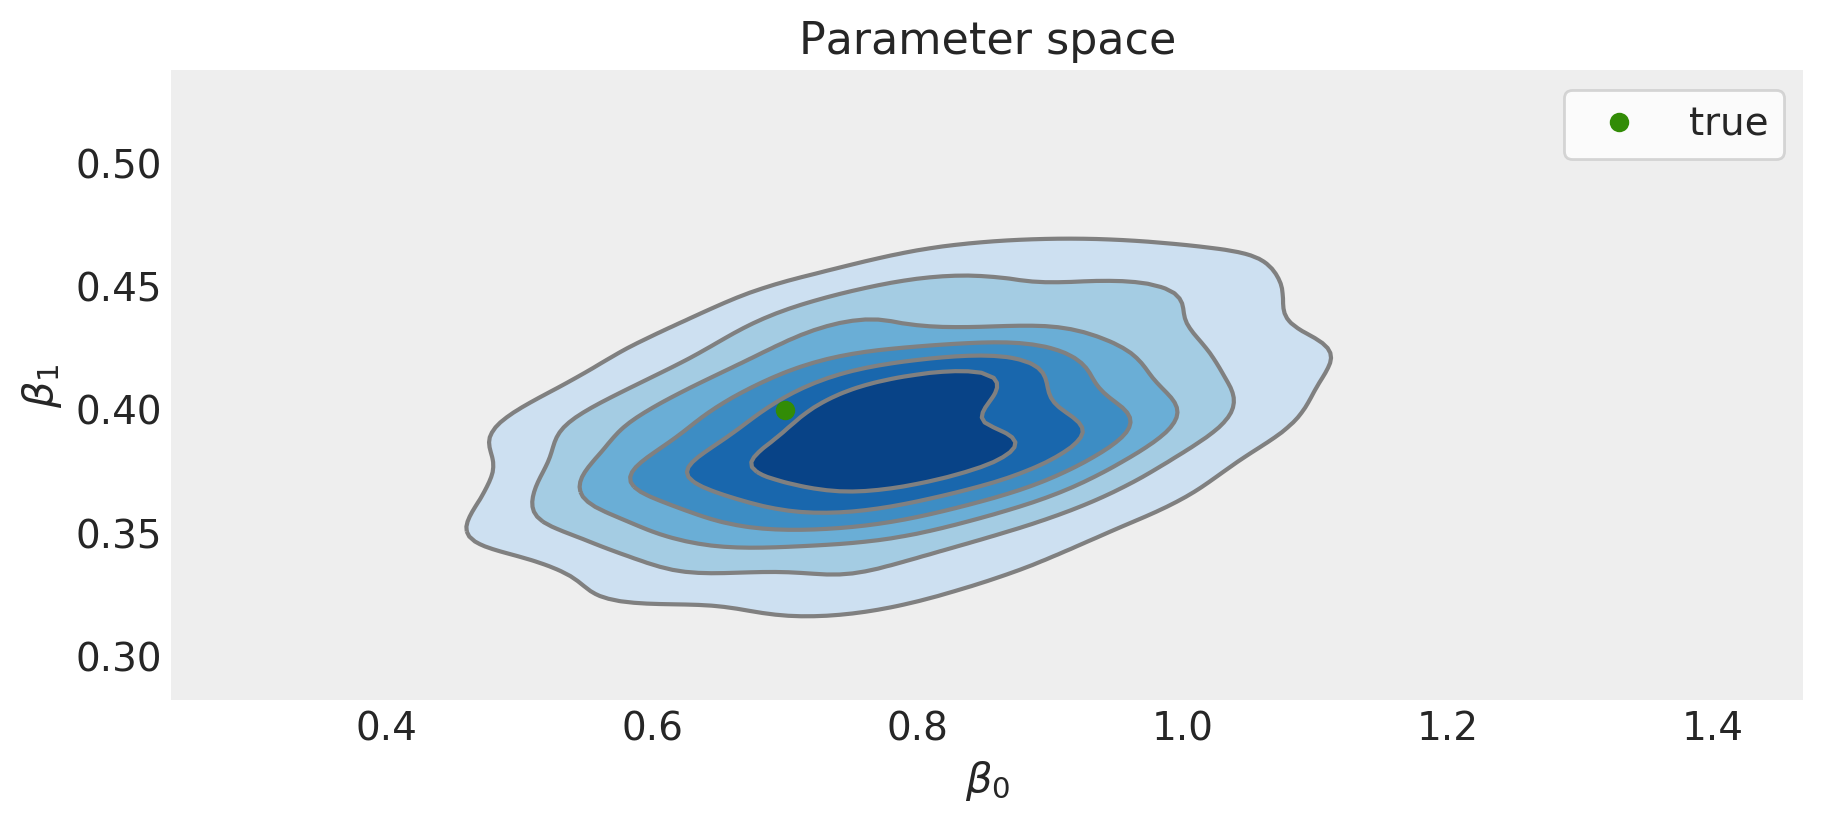

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4), gridspec_kw={"width_ratios": [1]})

az.plot_kde(
    jdata.beta0,
    jdata.beta1,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax,
)
ax.plot(beta0_true, beta1_true, "C2o", label="true")
ax.set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax.legend(facecolor="white", frameon=True);

Once again, success (and looks even *better*)!

<center>
<img src="ipynb.images/happy-cat.gif" width=300 />
</center>

We are ready for GLMs!

## 3. Generalized Linear Models (GLM)

Generalized Linear Models is a technique to run similar simulations using what's known as a [patsy formula](https://patsy.readthedocs.io/en/latest/formulas.html) thar depicts the linear relationship between the data likelihood variable `y` and the hidden effect variables $\beta_0, \cdots \beta_N$.

>**Note**: patsy formulas are not limited to linear effects! Indeed any effect can be modelled, including polynomial powers, exponentials, lograithms, sinusoids, etc. Here's the patsy formula for a linear effect, a quadratic effect, and an exponential effect all in one model: `y ~ 1 + x + x**2 + exp(x)`

In [10]:
dir(pm.glm.families)

['Binomial',
 'Family',
 'Identity',
 'NegativeBinomial',
 'Normal',
 'Poisson',
 'StudentT',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'copy',
 'exp',
 'identity',
 'inverse',
 'logit',
 'modelcontext',
 'np',
 'numbers',
 'pm_dists',
 'tt']

For example, this is how we set two hidden linear variables $\beta_0$ and $\beta_1$, using our last Bernoulli-like `data`:

In [16]:
with pm.Model() as mdl_ols_glm:
    # setup model with binomial likelihood (which uses HalfCauchy for error prior)
    pm.glm.GLM.from_formula('y ~ 1 + x', data, family=pm.glm.families.Binomial())

In [17]:
with mdl_ols_glm:
    traces_ols_glm = pm.sample(1000, tune=2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 687.97it/s]


In [18]:
az.summary(traces_ols_glm, round_to=3)

d:\Anaconda3.5.1\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.797,0.154,0.512,1.075,0.004,0.003,1190.618,1190.618,1169.145,1002.057,1.006
x,0.396,0.035,0.323,0.455,0.001,0.001,1186.136,1186.136,1202.124,1454.645,0.999


d:\Anaconda3.5.1\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E54E0EFC18>,
      dtype=object)

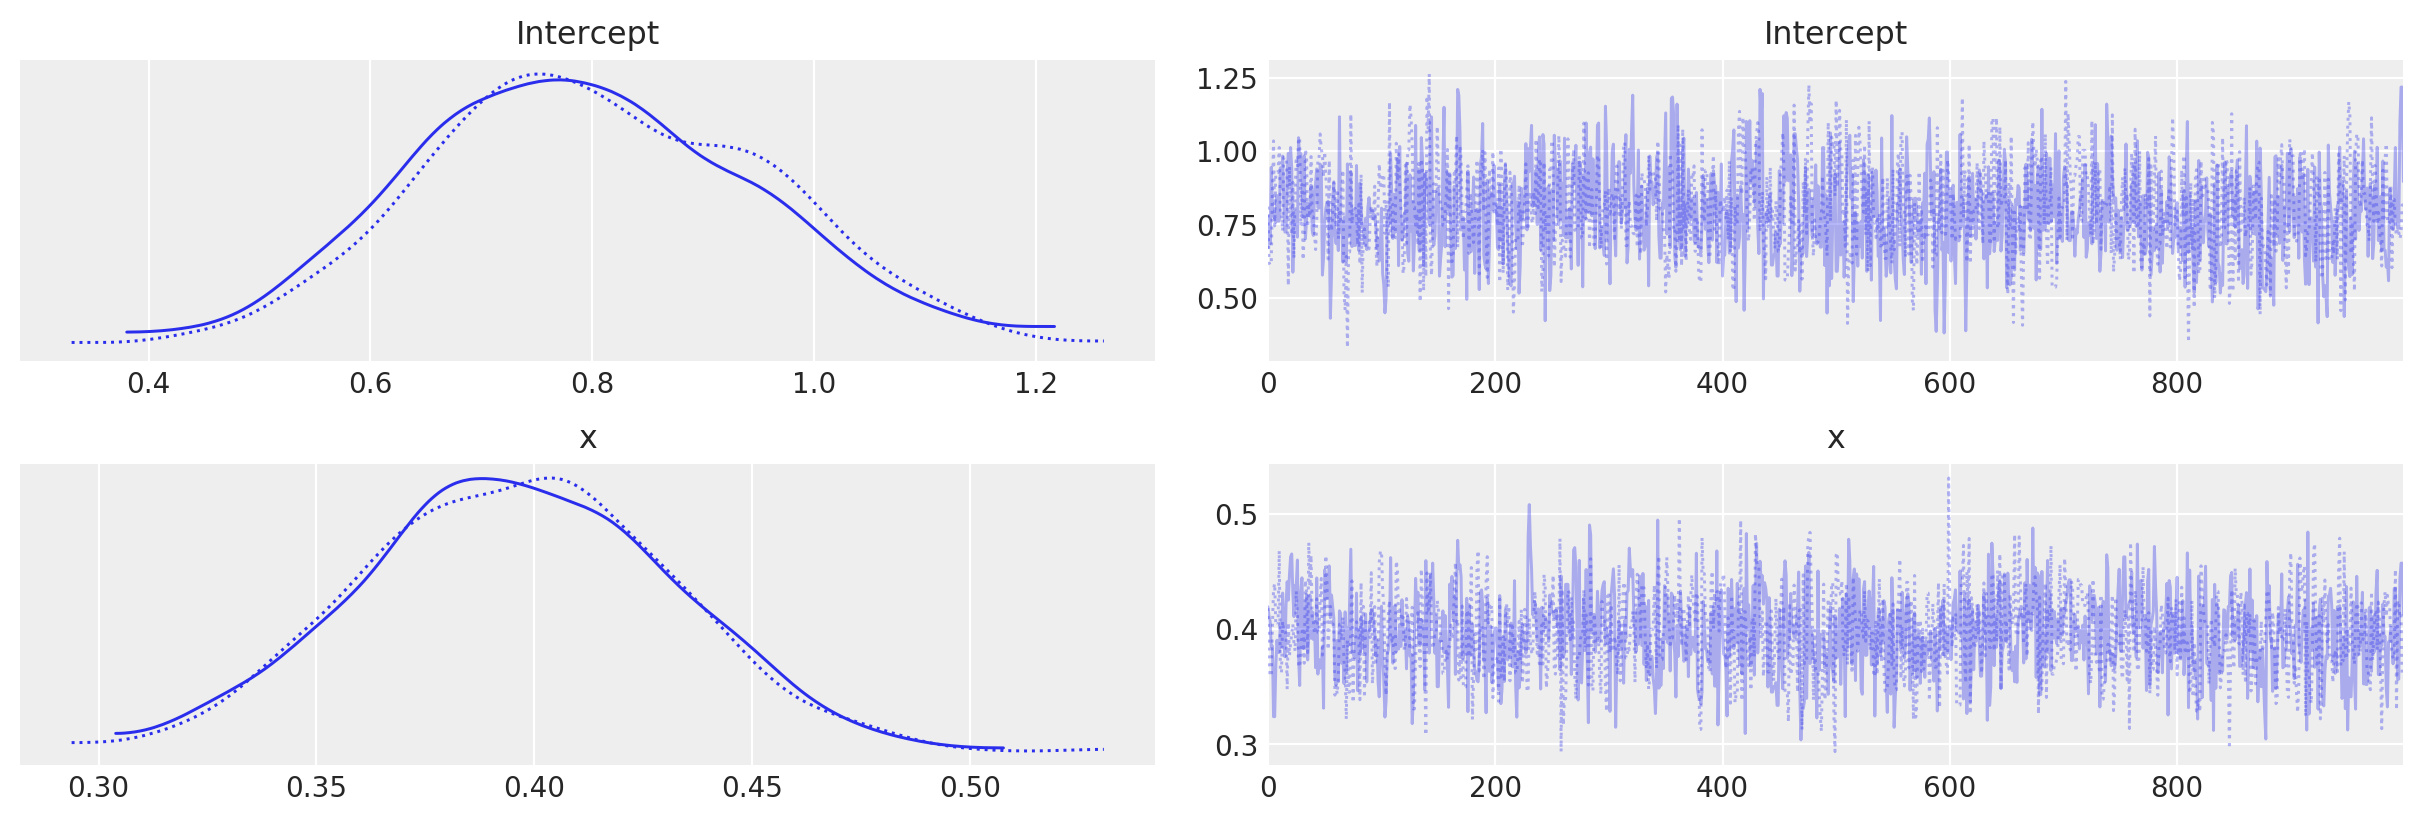

In [19]:
pm.traceplot(traces_ols_glm)

And that meshes well with our latent parameters:
```
beta0_true = 0.7
beta1_true = 0.4
```

...and... isn't that a lot *simpler*?

<center>
<img src="ipynb.images/happy-cat.gif" width=300 />
</center>

# 4. Celtics Four Factors Analysis
Here is an example of a class "*final project*", to make your lectures entertaining and relevant😎.

Although I love F1 and Tennis, the team sport I like (watching) the most is *basketball*. Baseball is too slow, american football too violent, and not enough goals scored in the most beautiful of all sports (soccer).

Also, we live in a city with a storied *basketball* franchise!

<br />
<center>
<img src="ipynb.images/celtics.avif" width=1000 />
</center>

Justin Jacobs has an [idea](https://squared2020.com/2017/09/05/introduction-to-olivers-four-factors/) about what it takes to win in basketball. He posits a 40/25/20/15 importance distribution for four important factors.

We will use the 2022 (complete) season Celtics results and an mcmc simulation to see if he's right and how much do these factors drive Celtics performance. Then we'll also peak into the 23 season.

## Four Factors

The term is based on what [Dean Oliver](http://www.basketballonpaper.com/) called the [Four Factors of Basketball Success](https://www.basketball-reference.com/about/factors.html), which are:

- Shooting
- Turnovers
- Rebounding
- Free Throws

These are important for any team both on *offense* and *defense*, and for that reason we can think that we have 8 factors instead of 4 and they can be obtained from just the box scores. 

I will explain them a bit more in detail now.

### Shooting
As we all now, the team that gets more points wins basketball games. This factor is measured as the *Effective Field Goal Percentage* (EFG%):

$$
EFG\% = \frac{FGM + 0.5 FG3M}{FGA},
$$

where
- FGM: Field Goals Made
- FG3M: 3-Point Shots Made
- FGA: Field Goal Attempts

### Turnovers
Teams need to take care of the ball to get the best out of their possessions. This factor is measured with the *Turnover Percentage* (TOV%):

$$
TOV\% = \frac{TOV}{POSS},
$$

where
- TOV: Turnovers
- POSS: Amount of Possessions in the Season

### Rebounding
An offensive rebound is another way of making the best of possessions in case the team doesn't shoot the ball well, taking second (or more) chances to score. The offensive rebounding factor is the *Offensive Rebound Percentage* (ORB%):

$$
ORB\% = \frac{ORB}{ORB + OppDRB},
$$

where
- ORB: Offensive Rebounds
- OppDRB. Opponents's Defensive Rebounds

For the defensive rebounding factor, we can get the ORB% for the opponents (OppORB%, this is the one available in the NBA Stats Page) or the *Defensive Rebounding Percentage* (DRB%):

$$
DRB\% = \frac{DRB}{DRB + OppORB},
$$

where
- DRB: Defensive Rebounds
- OppORB. Opponents's Offensive Rebounds

### Free Throws
Lastly, one of the ways we can end a possession is by getting to the free throw line (except when getting shots because of technical or flagrant fouls). This is the relationship between the amount of free throws a team attempted (FTA) and the field goals attempted (FGA), the *Free Throw Rate* (FTRATE):

$$
FTRATE = \frac{FTA}{FGA}
$$

## 4.1 Computing NBA Four Factors Importance
Luckily, the NBA Stats Page has these factors already computed for a lot of seasons for us to use!
```
pip install nba-api
```
[Legend](https://www.nba.com/stats/help/glossary) of metrics used.

In [20]:
# Imports
from nba_api.stats.endpoints import leaguedashteamstats
from sklearn.linear_model import LinearRegression
import time

Let's start by getting the Four Factors data for 20 seasons in *one* DataFrame.

In [21]:
four_factors = pd.DataFrame()
for i in range(20):
    # Building the Season String (ie. 2020-21)
    season_str = f"{2001 + i}-{2 + i:02d}"
    # Let's make some attempts to obtain the data, since we might be doing too many requests...
    for attempt in range(5):
        try:
            season_factors = leaguedashteamstats.LeagueDashTeamStats(
                season=season_str, measure_type_detailed_defense="Four Factors",
            ).get_data_frames()[0]
            season_factors["season"] = 2002 + i
            # Try to get the information for the season, getting only the columns we need
            four_factors = pd.concat(
                [four_factors, season_factors],
                axis=0,
            )
        except:
            # If we get an error we go to sleep for some time
            print("Exception!")
            time.sleep(10)
        else:
            # If everything's OK with the request, we continue
            break

Let's save this dataframe, just in case our library malfunctions one day...

In [119]:
four_factors.to_csv(
    r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba20-21.zip') 

In [35]:
four_factors.to_pickle(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba20-21.pkl')

Here's how to load it:
```
four_factors = pdame.from_csv(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba20-21.zip')
four_factors = pd.read_pickle(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba20-21.pkl')
```

In [23]:
# Get a random sample
four_factors.sample(20)

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,...,MIN_RANK,EFG_PCT_RANK,FTA_RATE_RANK,TM_TOV_PCT_RANK,OREB_PCT_RANK,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,season
23,1610612757,Portland Trail Blazers,82,21,61,0.256,3946.0,0.474,0.310,0.165,...,29,26,25,24,12,25,6,27,30,2006
1,1610612738,Boston Celtics,82,55,27,0.671,3961.0,0.518,0.243,0.144,...,12,15,18,15,19,2,16,15,10,2018
0,1610612737,Atlanta Hawks,67,20,47,0.299,3256.0,0.515,0.258,0.155,...,23,25,19,28,15,24,29,15,29,2020
9,1610612744,Golden State Warriors,82,57,25,0.695,3961.0,0.565,0.227,0.139,...,15,1,28,16,23,3,21,19,17,2019
21,1610612753,Orlando Magic,82,59,23,0.720,3946.0,0.520,0.351,0.149,...,27,3,3,16,29,1,6,25,3,2009
28,1610612762,Utah Jazz,82,51,31,0.622,3961.0,0.502,0.380,0.167,...,20,11,2,22,1,13,30,15,3,2007
29,1610612764,Washington Wizards,82,42,40,0.512,3966.0,0.484,0.375,0.148,...,17,21,3,5,7,24,20,2,24,2006
20,1610612760,Oklahoma City Thunder,82,49,33,0.598,3971.0,0.514,0.266,0.134,...,7,22,10,8,3,17,24,1,9,2019
21,1610612753,Orlando Magic,82,25,57,0.305,3946.0,0.512,0.238,0.147,...,23,21,21,17,25,17,12,16,28,2018
29,1610612764,Washington Wizards,82,44,38,0.537,4011.0,0.506,0.248,0.153,...,1,11,26,14,21,15,14,5,7,2014


### Adjusting our Linear Models
For each season, we will build a linear regression Model (in data space, not Bayesian parameter space) without intercept (using Scikit Learn `sklearn.linear_model`) that depends on our 8 factors (the 4 factors for the home team and the 4 factors for the visiting team) to the **Win Percentage (W%)** of each team. 

We will then just focus on the offensive factors' importance then, storing that data in a new DataFrame.

In [24]:
four_factors_models = pd.DataFrame(columns=["EFG_PCT", "FTA_RATE", "TM_TOV_PCT", "OREB_PCT"])
for i in range(20):
    # For each season, we will fit a linear model, trying to adjust it to the win percentage
    season = 2002 + i
    season_factors = four_factors.loc[
        four_factors["season"] == season,
        ["EFG_PCT", "FTA_RATE", "TM_TOV_PCT", "OREB_PCT", "OPP_EFG_PCT", "OPP_FTA_RATE", "OPP_TOV_PCT", "OPP_OREB_PCT"],
    ]
    model = LinearRegression(fit_intercept=False)
    model.fit(
        X=season_factors,
        y=four_factors.loc[four_factors["season"] == season, "W_PCT"],
    )
    season = 2002 + i
    
    # Put the 4 first factors (offensive)
    four_factors_models.loc[season] = np.abs(model.coef_[:4]) / np.sum(np.abs(model.coef_[:4]))

In [25]:
four_factors_models.head(20)

,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT
2002,0.408893,0.063766,0.409220,0.118122
2003,0.518899,0.040976,0.307262,0.132864
2004,0.432751,0.048626,0.317373,0.201250
2005,0.445683,0.046723,0.340023,0.167571
2006,0.414419,0.042803,0.310623,0.232155
2007,0.361529,0.013679,0.443143,0.181649
2008,0.408303,0.048344,0.342912,0.200441
2009,0.493474,0.019760,0.343015,0.143751
2010,0.407584,0.043092,0.377809,0.171514
2011,0.434156,0.080450,0.371815,0.113579


### Plot and Analysis

We can represent the relative importance of each factor as years go by on as a stacked box plot, since our factor importance sums 1 for every year.

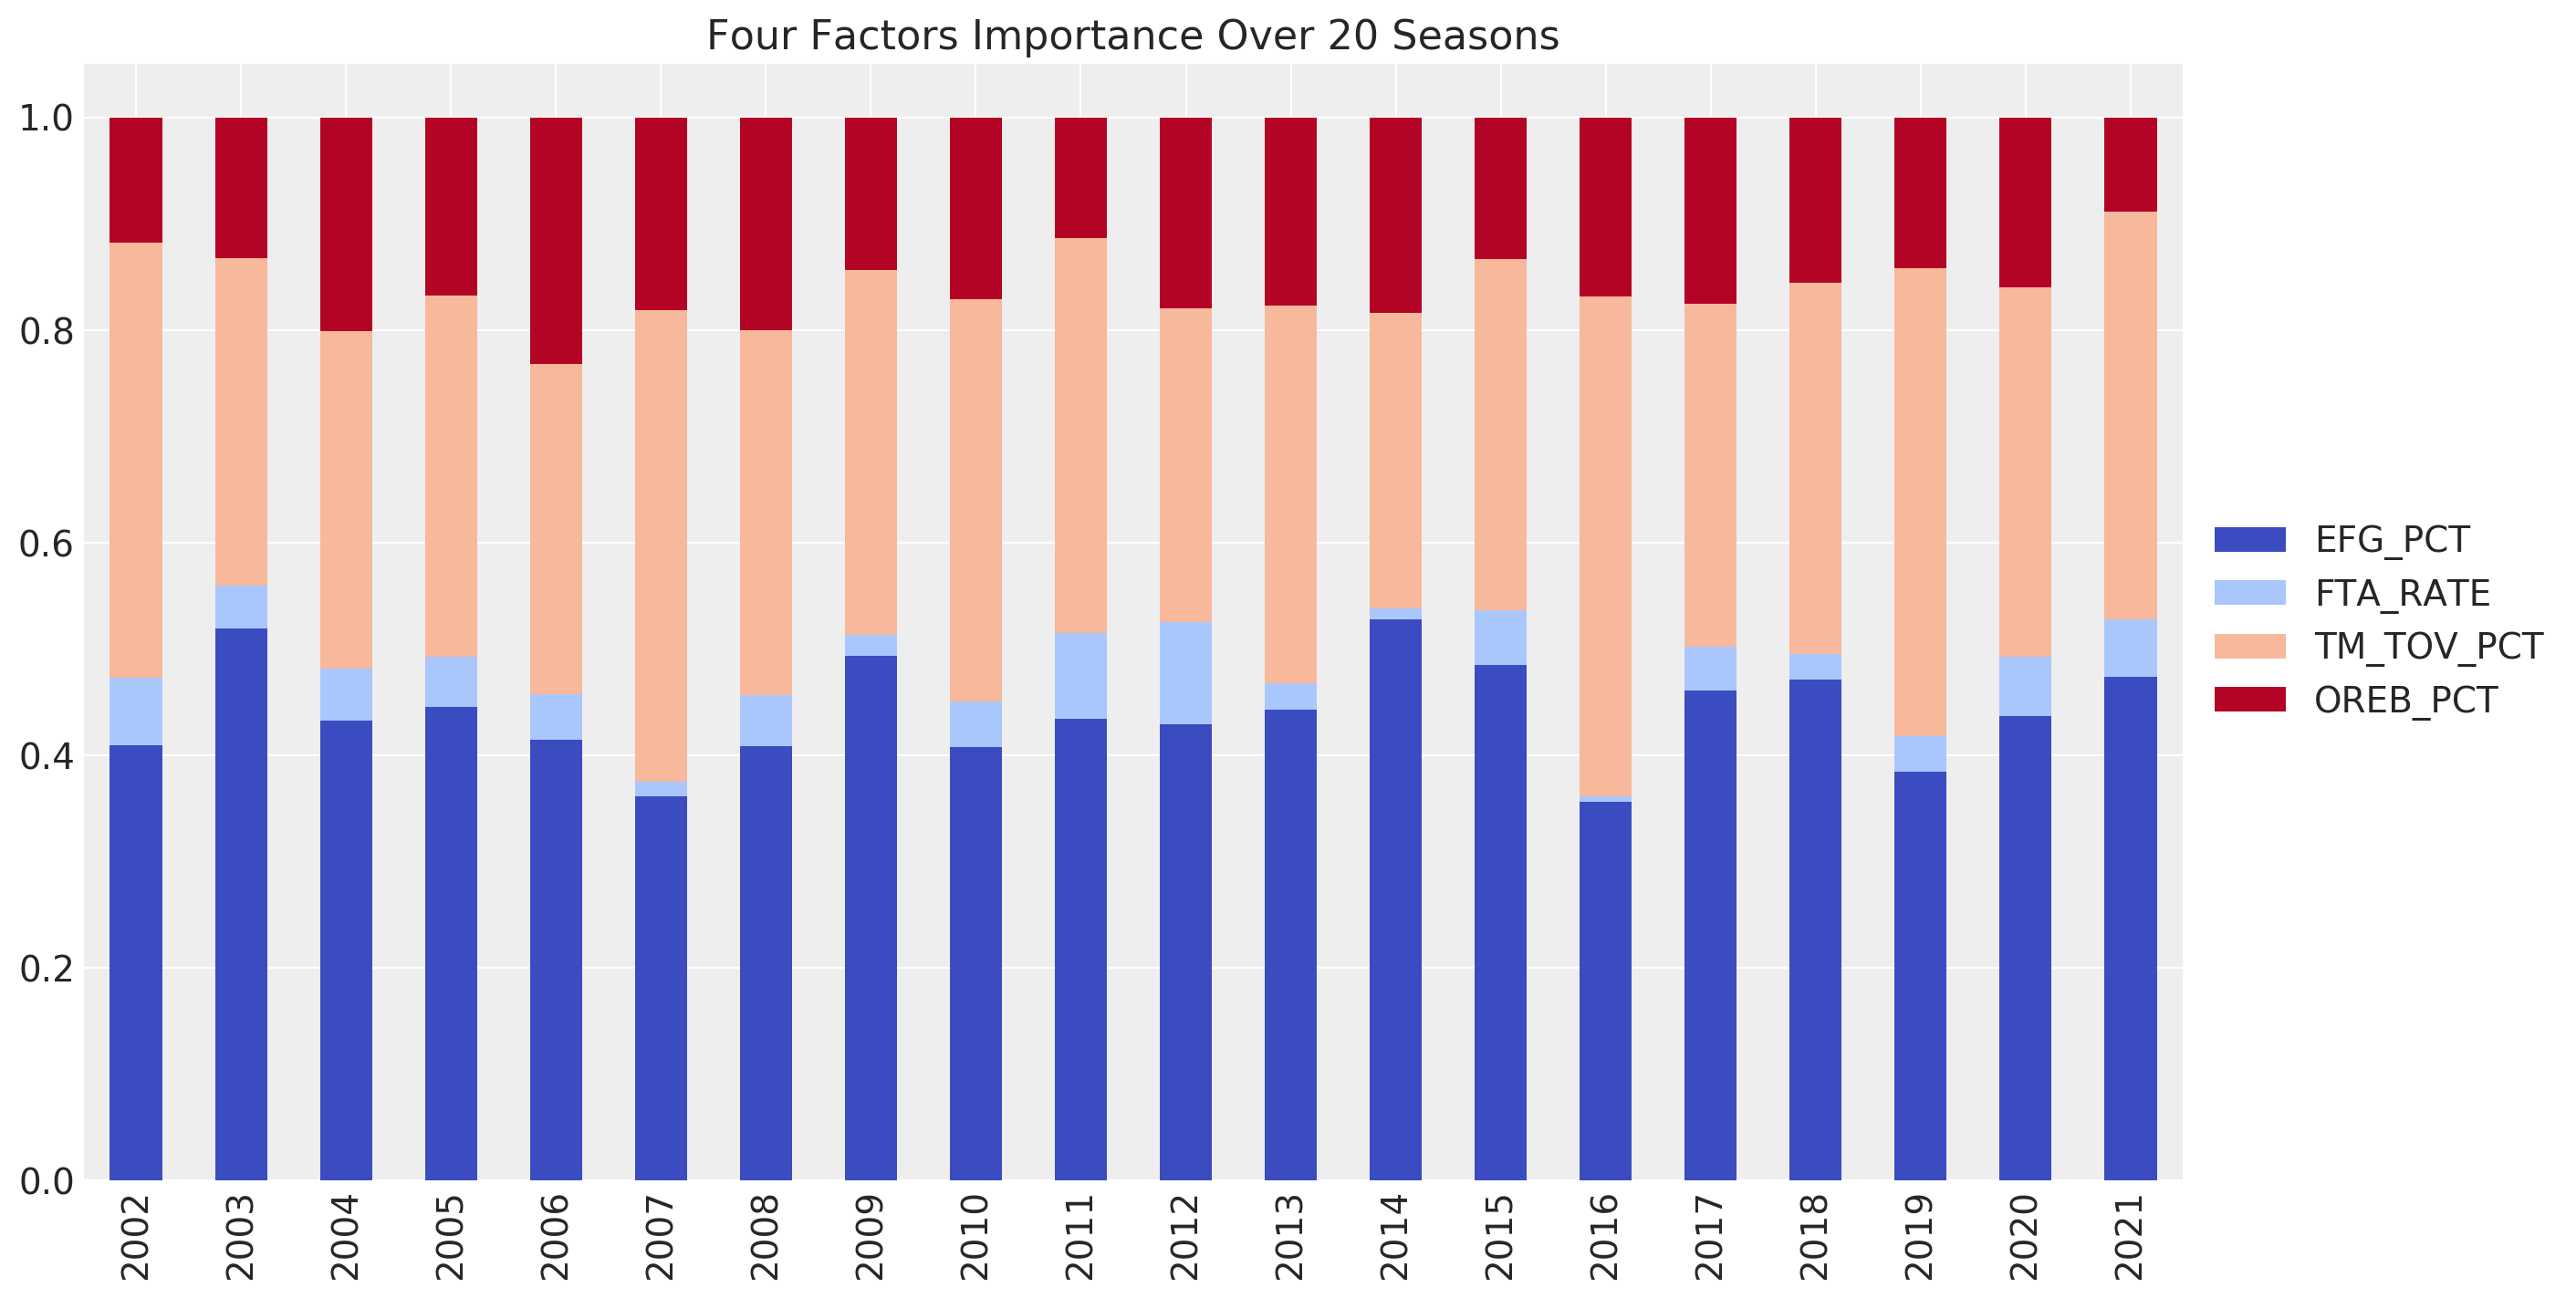

In [26]:
four_factors_models.plot.bar(
    stacked=True, cmap="coolwarm",
    figsize=(14, 7),
    title="Four Factors Importance Over 20 Seasons",
).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

In the past, Dean Oliver assigned the following importance to the offensive factors:

- Shooting (40%)
- Turnovers (25%)
- Rebounding (20%)
- Free Throws (15%)

Let's see which of these 20 years is closer to that distribution according to our models, using Euclidean distance.

In [27]:
# Get the argument for the closest row to the distribution above.
argmin = np.argmin(np.linalg.norm((four_factors_models - np.array([0.4, 0.15, 0.25, 0.20])), axis=1))
# Show the Series corresponding to that argument.
four_factors_models.iloc[argmin]

EFG_PCT       0.429392
FTA_RATE      0.095517
TM_TOV_PCT    0.295126
OREB_PCT      0.179964
Name: 2012, dtype: float64

As we can see, the closest season to that distribution was the **2011-12** Season. The *Heat* (with Lebron, Wade and Bosh) won the championship after defeating the Durant, Westbrook and Harden led *Thunder*. This season had 66 games and is the one where FTRATE was at its max.

The Four Factors can give us a good estimation of what it takes to win NBA games, and can be useful for teams to figure out what they may be lacking, in order to get in the best shape for the next season. But what is the best proportion of these four factors for *the way the game is being played today*?

## 4.2 Players & Teams
Let's get the NBA player dictionary:

In [28]:
from nba_api.stats.static import players
player_dict = players.get_players()
player_dict

[{'id': 76001,
  'full_name': 'Alaa Abdelnaby',
  'first_name': 'Alaa',
  'last_name': 'Abdelnaby',
  'is_active': False},
 {'id': 76002,
  'full_name': 'Zaid Abdul-Aziz',
  'first_name': 'Zaid',
  'last_name': 'Abdul-Aziz',
  'is_active': False},
 {'id': 76003,
  'full_name': 'Kareem Abdul-Jabbar',
  'first_name': 'Kareem',
  'last_name': 'Abdul-Jabbar',
  'is_active': False},
 {'id': 51,
  'full_name': 'Mahmoud Abdul-Rauf',
  'first_name': 'Mahmoud',
  'last_name': 'Abdul-Rauf',
  'is_active': False},
 {'id': 1505,
  'full_name': 'Tariq Abdul-Wahad',
  'first_name': 'Tariq',
  'last_name': 'Abdul-Wahad',
  'is_active': False},
 {'id': 949,
  'full_name': 'Shareef Abdur-Rahim',
  'first_name': 'Shareef',
  'last_name': 'Abdur-Rahim',
  'is_active': False},
 {'id': 76005,
  'full_name': 'Tom Abernethy',
  'first_name': 'Tom',
  'last_name': 'Abernethy',
  'is_active': False},
 {'id': 76006,
  'full_name': 'Forest Able',
  'first_name': 'Forest',
  'last_name': 'Able',
  'is_active': Fa

In [29]:
[player for player in player_dict if 'Tatum' in player['full_name']]

[{'id': 78294,
  'full_name': 'Earl Tatum',
  'first_name': 'Earl',
  'last_name': 'Tatum',
  'is_active': False},
 {'id': 1628369,
  'full_name': 'Jayson Tatum',
  'first_name': 'Jayson',
  'last_name': 'Tatum',
  'is_active': True}]

In [42]:
import pickle

# save dictionary to file
with open(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba20-21-players.pkl', 'wb') as fp:
    pickle.dump(player_dict, fp)

To read:
```
with open(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba20-21-players.pkl', 'rb') as fp:
    player_dict = pickle.load(fp)
```

Let's find Jason Tatum, and also the Celtics as a team:

In [30]:
# Use ternary operator or write function 
# Names are case sensitive
tatum = [player for player in player_dict if player['full_name'] == 'Jayson Tatum'][0]
tatum_id = tatum['id']

# find team Ids
from nba_api.stats.static import teams 
teams = teams.get_teams()
BOS = [x for x in teams if x['full_name'] == 'Boston Celtics'][0]
BOS_id = BOS['id']

tatum_id, BOS_id

(1628369, 1610612738)

In [31]:
teams

[{'id': 1610612737,
  'full_name': 'Atlanta Hawks',
  'abbreviation': 'ATL',
  'nickname': 'Hawks',
  'city': 'Atlanta',
  'state': 'Atlanta',
  'year_founded': 1949},
 {'id': 1610612738,
  'full_name': 'Boston Celtics',
  'abbreviation': 'BOS',
  'nickname': 'Celtics',
  'city': 'Boston',
  'state': 'Massachusetts',
  'year_founded': 1946},
 {'id': 1610612739,
  'full_name': 'Cleveland Cavaliers',
  'abbreviation': 'CLE',
  'nickname': 'Cavaliers',
  'city': 'Cleveland',
  'state': 'Ohio',
  'year_founded': 1970},
 {'id': 1610612740,
  'full_name': 'New Orleans Pelicans',
  'abbreviation': 'NOP',
  'nickname': 'Pelicans',
  'city': 'New Orleans',
  'state': 'Louisiana',
  'year_founded': 2002},
 {'id': 1610612741,
  'full_name': 'Chicago Bulls',
  'abbreviation': 'CHI',
  'nickname': 'Bulls',
  'city': 'Chicago',
  'state': 'Illinois',
  'year_founded': 1966},
 {'id': 1610612742,
  'full_name': 'Dallas Mavericks',
  'abbreviation': 'DAL',
  'nickname': 'Mavericks',
  'city': 'Dallas',

In [45]:
with open(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba20-21-teams.pkl', 'wb') as fp:
    pickle.dump(teams, fp)

## 4.3 NBA Four factors
Let's get the 4 factors for each team for the posted season:

In [127]:
season_factors = leaguedashteamstats.LeagueDashTeamStats(
    season="2022-23", measure_type_detailed_defense="Four Factors",
).get_data_frames()
season_factors

[       TEAM_ID               TEAM_NAME  GP   W   L  W_PCT     MIN  EFG_PCT  \
 0   1610612737           Atlanta Hawks  82  41  41  0.500  3971.0    0.541   
 1   1610612738          Boston Celtics  82  57  25  0.695  3996.0    0.566   
 2   1610612751           Brooklyn Nets  82  45  37  0.549  3946.0    0.562   
 3   1610612766       Charlotte Hornets  82  27  55  0.329  3966.0    0.516   
 4   1610612741           Chicago Bulls  82  40  42  0.488  3981.0    0.550   
 5   1610612739     Cleveland Cavaliers  82  51  31  0.622  3976.0    0.556   
 6   1610612742        Dallas Mavericks  82  38  44  0.463  3986.0    0.565   
 7   1610612743          Denver Nuggets  82  53  29  0.646  3951.0    0.573   
 8   1610612765         Detroit Pistons  82  17  65  0.207  3961.0    0.520   
 9   1610612744   Golden State Warriors  82  44  38  0.537  3966.0    0.571   
 10  1610612745         Houston Rockets  82  22  60  0.268  3951.0    0.516   
 11  1610612754          Indiana Pacers  82  35  47 

In [32]:
season_factors = leaguedashteamstats.LeagueDashTeamStats(
    season="2023-24", measure_type_detailed_defense="Four Factors",
).get_data_frames()
season_factors

[       TEAM_ID               TEAM_NAME  GP   W   L  W_PCT     MIN  EFG_PCT  \
 0   1610612737           Atlanta Hawks  72  33  39  0.458  3476.0    0.540   
 1   1610612738          Boston Celtics  72  57  15  0.792  3481.0    0.578   
 2   1610612751           Brooklyn Nets  73  28  45  0.384  3529.0    0.532   
 3   1610612766       Charlotte Hornets  72  18  54  0.250  3466.0    0.525   
 4   1610612741           Chicago Bulls  73  35  38  0.479  3559.0    0.532   
 5   1610612739     Cleveland Cavaliers  73  44  29  0.603  3529.0    0.556   
 6   1610612742        Dallas Mavericks  72  43  29  0.597  3456.0    0.564   
 7   1610612743          Denver Nuggets  73  51  22  0.699  3509.0    0.560   
 8   1610612765         Detroit Pistons  73  12  61  0.164  3519.0    0.528   
 9   1610612744   Golden State Warriors  72  38  34  0.528  3486.0    0.553   
 10  1610612745         Houston Rockets  72  37  35  0.514  3486.0    0.530   
 11  1610612754          Indiana Pacers  74  41  33 

In [47]:
with open(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba20-21-season-factors.pkl', 'wb') as fp:
    pickle.dump(season_factors, fp)

In [48]:
four_factors.loc[four_factors["season"] == 2021].sort_values(
    by="TM_TOV_PCT", ascending=True)[["TEAM_NAME", "TM_TOV_PCT"]].head(5)

,TEAM_NAME,TM_TOV_PCT
24,Portland Trail Blazers,0.112
26,San Antonio Spurs,0.113
6,Dallas Mavericks,0.123
23,Phoenix Suns,0.126
21,Orlando Magic,0.129


In [36]:
four_factors.loc[four_factors["season"] == 2021].sort_values(
    by="TM_TOV_PCT", ascending=True)[["TEAM_NAME", "TM_TOV_PCT"]].head(5)

,TEAM_NAME,TM_TOV_PCT
24,Portland Trail Blazers,0.112
26,San Antonio Spurs,0.113
6,Dallas Mavericks,0.123
23,Phoenix Suns,0.126
21,Orlando Magic,0.129


## 4.4 Game data
Let's look at each game in the season:

In [128]:
# First we import the endpoint
# We will be using pandas dataframes to manipulate the data
from nba_api.stats.endpoints import playergamelog
import pandas as pd 

#Call the API endpoint passing in Tatum's ID & which season 
gamelog_tatum = playergamelog.PlayerGameLog(player_id=tatum_id, season = '2022')

#Converts gamelog object into a pandas dataframe
#can also convert to JSON or dictionary  
df_tatum_games_2022 = gamelog_tatum.get_data_frames()
df_tatum_games_2022

[   SEASON_ID  Player_ID     Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  \
 0      22022    1628369  0022201206  APR 07, 2023  BOS vs. TOR  W   20    7   
 1      22022    1628369  0022201181  APR 04, 2023    BOS @ PHI  L   38    7   
 2      22022    1628369  0022201152  MAR 31, 2023  BOS vs. UTA  W   36   12   
 3      22022    1628369  0022201146  MAR 30, 2023    BOS @ MIL  W   31   12   
 4      22022    1628369  0022201130  MAR 28, 2023    BOS @ WAS  L   32   11   
 ..       ...        ...         ...           ...          ... ..  ...  ...   
 69     22022    1628369  0022200072  OCT 28, 2022  BOS vs. CLE  L   42   11   
 70     22022    1628369  0022200047  OCT 24, 2022    BOS @ CHI  L   35    8   
 71     22022    1628369  0022200030  OCT 22, 2022    BOS @ ORL  W   38   14   
 72     22022    1628369  0022200022  OCT 21, 2022    BOS @ MIA  W   37   10   
 73     22022    1628369  0022200001  OCT 18, 2022  BOS vs. PHI  W   39   13   
 
     FGA  FG_PCT  ...  DREB  REB  AST 

Here are all the games Jason Tatum played in:

In [38]:
# First we import the endpoint
# We will be using pandas dataframes to manipulate the data
from nba_api.stats.endpoints import playergamelog
import pandas as pd 

#Call the API endpoint passing in Tatum's ID & which season 
gamelog_tatum = playergamelog.PlayerGameLog(player_id=tatum_id, season = '2023')

#Converts gamelog object into a pandas dataframe
#can also convert to JSON or dictionary  
df_tatum_games_2023 = gamelog_tatum.get_data_frames()
df_tatum_games_2023

[   SEASON_ID  Player_ID     Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  \
 0      22023    1628369  0022301034  MAR 25, 2024    BOS @ ATL  L   39   13   
 1      22023    1628369  0022301023  MAR 23, 2024    BOS @ CHI  W   37    8   
 2      22023    1628369  0022300998  MAR 20, 2024  BOS vs. MIL  W   39    9   
 3      22023    1628369  0022300980  MAR 17, 2024    BOS @ WAS  W   27    8   
 4      22023    1628369  0022300955  MAR 14, 2024  BOS vs. PHX  W   33   10   
 ..       ...        ...         ...           ...          ... ..  ...  ...   
 62     22023    1628369  0022300136  NOV 04, 2023    BOS @ BKN  W   41   10   
 63     22023    1628369  0022300118  NOV 01, 2023  BOS vs. IND  W   27    9   
 64     22023    1628369  0022300103  OCT 30, 2023    BOS @ WAS  W   28   14   
 65     22023    1628369  0022300080  OCT 27, 2023  BOS vs. MIA  W   41    9   
 66     22023    1628369  0022300065  OCT 25, 2023    BOS @ NYK  W   39   13   
 
     FGA  FG_PCT  ...  DREB  REB  AST 

In [51]:
with open(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba20-21-tatum.pkl', 'wb') as fp:
    pickle.dump(df_tatum_games_2022, fp)

Let's explore APIs:

In [129]:
from nba_api.stats import endpoints
dir(endpoints)

['AllTimeLeadersGrids',
 'AssistLeaders',
 'AssistTracker',
 'BoxScoreAdvancedV2',
 'BoxScoreDefensive',
 'BoxScoreFourFactorsV2',
 'BoxScoreMatchups',
 'BoxScoreMiscV2',
 'BoxScorePlayerTrackV2',
 'BoxScoreScoringV2',
 'BoxScoreSimilarityScore',
 'BoxScoreSummaryV2',
 'BoxScoreTraditionalV2',
 'BoxScoreUsageV2',
 'CommonAllPlayers',
 'CommonPlayerInfo',
 'CommonPlayoffSeries',
 'CommonTeamRoster',
 'CommonTeamYears',
 'CumeStatsPlayer',
 'CumeStatsPlayerGames',
 'CumeStatsTeam',
 'CumeStatsTeamGames',
 'DefenseHub',
 'DraftBoard',
 'DraftCombineDrillResults',
 'DraftCombineNonStationaryShooting',
 'DraftCombinePlayerAnthro',
 'DraftCombineSpotShooting',
 'DraftCombineStats',
 'DraftHistory',
 'FantasyWidget',
 'FranchiseHistory',
 'FranchiseLeaders',
 'FranchisePlayers',
 'GLAlumBoxScoreSimilarityScore',
 'GameRotation',
 'HomePageLeaders',
 'HomePageV2',
 'HustleStatsBoxScore',
 'InfographicFanDuelPlayer',
 'LeadersTiles',
 'LeagueDashLineups',
 'LeagueDashOppPtShot',
 'LeagueDashPla

Here's an API I'm interested in:

In [40]:
from nba_api.stats.endpoints import BoxScoreFourFactorsV2
dir(BoxScoreFourFactorsV2)

['DataSet',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'data_sets',
 'endpoint',
 'expected_data',
 'get_available_data',
 'get_data_frames',
 'get_dict',
 'get_json',
 'get_normalized_dict',
 'get_normalized_json',
 'get_request',
 'get_request_url',
 'get_response',
 'headers',
 'load_response',
 'nba_response',
 'player_stats',
 'team_stats']

In [54]:
import inspect
inspect.signature(BoxScoreFourFactorsV2.DataSet.__init__)

<Signature (self, data)>

Let's call it:

In [41]:
bs = BoxScoreFourFactorsV2(game_id='0022201097')
bs.get_data_frames()

[       GAME_ID     TEAM_ID TEAM_ABBREVIATION TEAM_CITY  PLAYER_ID  \
 0   0022201097  1610612754               IND   Indiana    1631097   
 1   0022201097  1610612754               IND   Indiana    1630174   
 2   0022201097  1610612754               IND   Indiana    1626167   
 3   0022201097  1610612754               IND   Indiana    1629614   
 4   0022201097  1610612754               IND   Indiana    1630169   
 5   0022201097  1610612754               IND   Indiana    1627741   
 6   0022201097  1610612754               IND   Indiana     204456   
 7   0022201097  1610612754               IND   Indiana    1629670   
 8   0022201097  1610612754               IND   Indiana    1630543   
 9   0022201097  1610612754               IND   Indiana     201949   
 10  0022201097  1610612754               IND   Indiana    1630188   
 11  0022201097  1610612754               IND   Indiana     201588   
 12  0022201097  1610612754               IND   Indiana    1629052   
 13  0022201097  161

In [42]:
bs.get_data_frames()[1]

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT
0,0022201097,1610612754,Pacers,IND,Indiana,240.000000:00,0.488,0.262,0.162,0.122,0.570,0.204,0.140,0.231
1,0022201097,1610612738,Celtics,BOS,Boston,240.000000:00,0.570,0.204,0.140,0.173,0.488,0.262,0.162,0.163


In [56]:
with open(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba20-21-BoxScoreFourFactorsV2.pkl', 'wb') as fp:
    pickle.dump(bs.get_data_frames(), fp)

Great! We found a way to get the four factors for *any* game of the season.

## 4.5 Celtics 2022 Four factors
So, first, let's get the games the Celtics played in during the 2022 season:

In [130]:
from nba_api.stats.endpoints import teamgamelog

#Call the API endpoint passing in Celtics's ID & which season 
gamelog_bos = teamgamelog.TeamGameLog(team_id=BOS_id, season = '2022')

#Converts gamelog object into a pandas dataframe
#can also convert to JSON or dictionary  
df_bos_games_2022 = gamelog_bos.get_data_frames()
df_bos_games_2022

[       Team_ID     Game_ID     GAME_DATE      MATCHUP WL   W   L  W_PCT  MIN  \
 0   1610612738  0022201216  APR 09, 2023  BOS vs. ATL  W  57  25  0.695  240   
 1   1610612738  0022201206  APR 07, 2023  BOS vs. TOR  W  56  25  0.691  240   
 2   1610612738  0022201192  APR 05, 2023  BOS vs. TOR  W  55  25  0.688  240   
 3   1610612738  0022201181  APR 04, 2023    BOS @ PHI  L  54  25  0.684  240   
 4   1610612738  0022201152  MAR 31, 2023  BOS vs. UTA  W  54  24  0.692  240   
 ..         ...         ...           ...          ... ..  ..  ..    ...  ...   
 77  1610612738  0022200072  OCT 28, 2022  BOS vs. CLE  L   3   2  0.600  265   
 78  1610612738  0022200047  OCT 24, 2022    BOS @ CHI  L   3   1  0.750  240   
 79  1610612738  0022200030  OCT 22, 2022    BOS @ ORL  W   3   0  1.000  240   
 80  1610612738  0022200022  OCT 21, 2022    BOS @ MIA  W   2   0  1.000  240   
 81  1610612738  0022200001  OCT 18, 2022  BOS vs. PHI  W   1   0  1.000  240   
 
     FGM  ...  FT_PCT  ORE

In [58]:
with open(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba22-bos-games.pkl', 'wb') as fp:
    pickle.dump(df_bos_games_2022, fp)

In [132]:
df_bos_games_2022[0]

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612738,0022201216,"APR 09, 2023",BOS vs. ATL,W,57,25,0.695,240,42,...,0.786,12,35,47,33,5,3,15,13,120
1,1610612738,0022201206,"APR 07, 2023",BOS vs. TOR,W,56,25,0.691,240,45,...,0.762,13,40,53,37,4,7,19,14,121
2,1610612738,0022201192,"APR 05, 2023",BOS vs. TOR,W,55,25,0.688,240,38,...,0.556,11,37,48,20,5,7,15,14,97
3,1610612738,0022201181,"APR 04, 2023",BOS @ PHI,L,54,25,0.684,240,38,...,0.625,13,30,43,28,4,4,8,17,101
4,1610612738,0022201152,"MAR 31, 2023",BOS vs. UTA,W,54,24,0.692,240,42,...,0.955,10,32,42,27,8,4,11,14,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1610612738,0022200072,"OCT 28, 2022",BOS vs. CLE,L,3,2,0.600,265,42,...,0.813,5,29,34,28,9,2,19,27,123
78,1610612738,0022200047,"OCT 24, 2022",BOS @ CHI,L,3,1,0.750,240,37,...,0.833,14,31,45,26,5,7,10,24,102
79,1610612738,0022200030,"OCT 22, 2022",BOS @ ORL,W,3,0,1.000,240,42,...,0.821,7,30,37,24,5,6,8,21,126
80,1610612738,0022200022,"OCT 21, 2022",BOS @ MIA,W,2,0,1.000,240,41,...,1.000,12,31,43,17,4,11,19,23,111


We see that this dataset does *not* include the 4 factors, and so we need to get them using the `BoxScoreFourFactorsV2` api.

In [61]:
df_bos_games_2022[0].loc[0]

Team_ID        1610612738
Game_ID        0022201216
GAME_DATE    APR 09, 2023
MATCHUP       BOS vs. ATL
WL                      W
W                      57
L                      25
W_PCT               0.695
MIN                   240
FGM                    42
FGA                    89
FG_PCT              0.472
FG3M                   25
FG3A                   54
FG3_PCT             0.463
FTM                    11
FTA                    14
FT_PCT              0.786
OREB                   12
DREB                   35
REB                    47
AST                    33
STL                     5
BLK                     3
TOV                    15
PF                     13
PTS                   120
Name: 0, dtype: object

In [62]:
df_bos_games_2022[0]['Game_ID'].values

array(['0022201216', '0022201206', '0022201192', '0022201181',
       '0022201152', '0022201146', '0022201130', '0022201116',
       '0022201097', '0022201081', '0022201062', '0022201053',
       '0022201039', '0022201024', '0022201008', '0022200986',
       '0022200971', '0022200969', '0022200948', '0022200935',
       '0022200921', '0022200908', '0022200887', '0022200877',
       '0022200869', '0022200855', '0022200838', '0022200824',
       '0022200808', '0022200788', '0022200772', '0022200749',
       '0022200730', '0022200714', '0022200707', '0022200692',
       '0022200679', '0022200656', '0022200642', '0022200627',
       '0022200621', '0022200606', '0022200591', '0022200577',
       '0022200562', '0022200549', '0022200525', '0022200507',
       '0022200495', '0022200482', '0022200469', '0022200445',
       '0022200430', '0022200413', '0022200408', '0022200392',
       '0022200373', '0022200355', '0022200346', '0022200328',
       '0022200314', '0022200301', '0022200294', '00222

In [133]:
df = BoxScoreFourFactorsV2(game_id='0022201097').get_data_frames()[1]   
df

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT
0,0022201097,1610612754,Pacers,IND,Indiana,240.000000:00,0.488,0.262,0.162,0.122,0.570,0.204,0.140,0.231
1,0022201097,1610612738,Celtics,BOS,Boston,240.000000:00,0.570,0.204,0.140,0.173,0.488,0.262,0.162,0.163


In [134]:
four_factors_celtics_2022 = df.copy()
four_factors_celtics_2022

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT
0,0022201097,1610612754,Pacers,IND,Indiana,240.000000:00,0.488,0.262,0.162,0.122,0.570,0.204,0.140,0.231
1,0022201097,1610612738,Celtics,BOS,Boston,240.000000:00,0.570,0.204,0.140,0.173,0.488,0.262,0.162,0.163


In [135]:
df2 = BoxScoreFourFactorsV2(game_id='0022201081').get_data_frames()[1]   
df2

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT
0,0022201081,1610612758,Kings,SAC,Sacramento,240.000000:00,0.586,0.259,0.149,0.222,0.630,0.250,0.062,0.298
1,0022201081,1610612738,Celtics,BOS,Boston,240.000000:00,0.630,0.250,0.062,0.234,0.586,0.259,0.149,0.267


In [136]:
four_factors_celtics_2022 = pd.concat([df, df2])
four_factors_celtics_2022

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT
0,0022201097,1610612754,Pacers,IND,Indiana,240.000000:00,0.488,0.262,0.162,0.122,0.570,0.204,0.140,0.231
1,0022201097,1610612738,Celtics,BOS,Boston,240.000000:00,0.570,0.204,0.140,0.173,0.488,0.262,0.162,0.163
0,0022201081,1610612758,Kings,SAC,Sacramento,240.000000:00,0.586,0.259,0.149,0.222,0.630,0.250,0.062,0.298
1,0022201081,1610612738,Celtics,BOS,Boston,240.000000:00,0.630,0.250,0.062,0.234,0.586,0.259,0.149,0.267


In [67]:
four_factors_celtics_2022 = df.copy()
four_factors_celtics_2022 = pd.concat([four_factors_celtics_2022[four_factors_celtics_2022['TEAM_NAME'] == 'Celtics'], 
                                       df2[df2['TEAM_NAME'] == 'Celtics']],  ignore_index = True)
four_factors_celtics_2022

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT
0,0022201097,1610612738,Celtics,BOS,Boston,240.000000:00,0.57,0.204,0.140,0.173,0.488,0.262,0.162,0.163
1,0022201081,1610612738,Celtics,BOS,Boston,240.000000:00,0.63,0.250,0.062,0.234,0.586,0.259,0.149,0.267


This will take a few minutes! Alternatively, load dino's data.

In [137]:
four_factors_celtics_2022 = df.copy()
from tqdm import tqdm

for i in tqdm(df_bos_games_2022[0]['Game_ID'].values[1:]):
    df2 = BoxScoreFourFactorsV2(game_id=i).get_data_frames()[1]
    four_factors_celtics_2022 = pd.concat([four_factors_celtics_2022[four_factors_celtics_2022['TEAM_NAME'] == 'Celtics'], 
                                       df2[df2['TEAM_NAME'] == 'Celtics']],  ignore_index = True)
    time.sleep(1)
    
four_factors_celtics_2022

100%|██████████| 81/81 [01:32<00:00,  1.14s/it]


,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT
0,0022201097,1610612738,Celtics,BOS,Boston,240.000000:00,0.570,0.204,0.140,0.173,0.488,0.262,0.162,0.163
1,0022201206,1610612738,Celtics,BOS,Boston,240.000000:00,0.648,0.259,0.214,0.333,0.478,0.183,0.083,0.268
2,0022201192,1610612738,Celtics,BOS,Boston,240.000000:00,0.489,0.202,0.149,0.200,0.444,0.189,0.124,0.273
3,0022201181,1610612738,Celtics,BOS,Boston,240.000000:00,0.500,0.176,0.086,0.232,0.571,0.205,0.132,0.225
4,0022201152,1610612738,Celtics,BOS,Boston,240.000000:00,0.526,0.229,0.111,0.182,0.526,0.146,0.168,0.314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0022200072,1610612738,Celtics,BOS,Boston,265.000000:00,0.591,0.390,0.173,0.114,0.609,0.391,0.147,0.239
78,0022200047,1610612738,Celtics,BOS,Boston,240.000000:00,0.460,0.120,0.108,0.219,0.540,0.333,0.140,0.304
79,0022200030,1610612738,Celtics,BOS,Boston,240.000000:00,0.592,0.322,0.080,0.149,0.553,0.242,0.088,0.321
80,0022200022,1610612738,Celtics,BOS,Boston,240.000000:00,0.608,0.190,0.214,0.316,0.500,0.163,0.102,0.314


In [138]:
four_factors_celtics_2022_v2 = four_factors_celtics_2022.copy()
four_factors_celtics_2022_v2['PTS'] = df_bos_games_2022[0]['PTS']
four_factors_celtics_2022_v2['WL'] = df_bos_games_2022[0]['WL'].apply(lambda x:0 if x == "L" else 1)
four_factors_celtics_2022_v2

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PTS,WL
0,0022201097,1610612738,Celtics,BOS,Boston,240.000000:00,0.570,0.204,0.140,0.173,0.488,0.262,0.162,0.163,120,1
1,0022201206,1610612738,Celtics,BOS,Boston,240.000000:00,0.648,0.259,0.214,0.333,0.478,0.183,0.083,0.268,121,1
2,0022201192,1610612738,Celtics,BOS,Boston,240.000000:00,0.489,0.202,0.149,0.200,0.444,0.189,0.124,0.273,97,1
3,0022201181,1610612738,Celtics,BOS,Boston,240.000000:00,0.500,0.176,0.086,0.232,0.571,0.205,0.132,0.225,101,0
4,0022201152,1610612738,Celtics,BOS,Boston,240.000000:00,0.526,0.229,0.111,0.182,0.526,0.146,0.168,0.314,122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0022200072,1610612738,Celtics,BOS,Boston,265.000000:00,0.591,0.390,0.173,0.114,0.609,0.391,0.147,0.239,123,0
78,0022200047,1610612738,Celtics,BOS,Boston,240.000000:00,0.460,0.120,0.108,0.219,0.540,0.333,0.140,0.304,102,0
79,0022200030,1610612738,Celtics,BOS,Boston,240.000000:00,0.592,0.322,0.080,0.149,0.553,0.242,0.088,0.321,126,1
80,0022200022,1610612738,Celtics,BOS,Boston,240.000000:00,0.608,0.190,0.214,0.316,0.500,0.163,0.102,0.314,111,1


In [71]:
with open(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba22-4factors-celtics.pkl', 'wb') as fp:
    pickle.dump(four_factors_celtics_2022_v2, fp)

## 4.6 Mcmc Simulation
We are ready for our mcmc simulation! We use a Bernoulli data likelihood to model wins and losses for the season. Bernoulli is conditioned on a single probability factor, the probability of winning a game.

We will model wins/losses (the *dependent variable*) as a linear regression of the *four factors* (the *indepedent variables*), which will allow us to compare (by comparing their respective coefficients in parameter space) how important each of these four factors are with respect to each other in determing the win/loss proportion for the season. Cool, huh?

```
Shooting EFG_PCT EFG% = (FGM + 0.5 * FG3M) / FGA
Turnovers TM_TOV_PCT TOV% = TOV / POSS
Rebounding OREB_PCT ORB% = ORB/(ORB + Opp_ORB)
Free Throws FTA_RATE FT% = FTA/FGA
```

I start my sim with *normal* shapes for the priors of the four factors:

In [139]:
with pm.Model() as celtics_regression_model:
    shooting = pm.Data("shooting", four_factors_celtics_2022_v2["EFG_PCT"])
    turnovers = pm.Data("turnovers", four_factors_celtics_2022_v2["TM_TOV_PCT"])
    rebounding = pm.Data("rebounding", four_factors_celtics_2022_v2["OREB_PCT"])
    freethrows = pm.Data("freethrows", four_factors_celtics_2022_v2["FTA_RATE"])
    
    # priors
    beta_i = pm.Normal("beta_i", mu=0, sd=1)
    beta_shooting = pm.Normal("beta_shooting", mu=0, sd=1)
    beta_turnovers = pm.Normal("beta_turnovers", mu=0, sd=1)
    beta_rebounding = pm.Normal("beta_rebounding", mu=0, sd=1)
    beta_freethrows = pm.Normal("beta_freethrows", mu=0, sd=1)
    
    # linear model
    mu = beta_i + beta_shooting * shooting + beta_turnovers * turnovers + beta_rebounding * rebounding + beta_freethrows * freethrows
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    
    # likelihood
    pm.Bernoulli("WL", p=p, observed=four_factors_celtics_2022_v2["WL"])

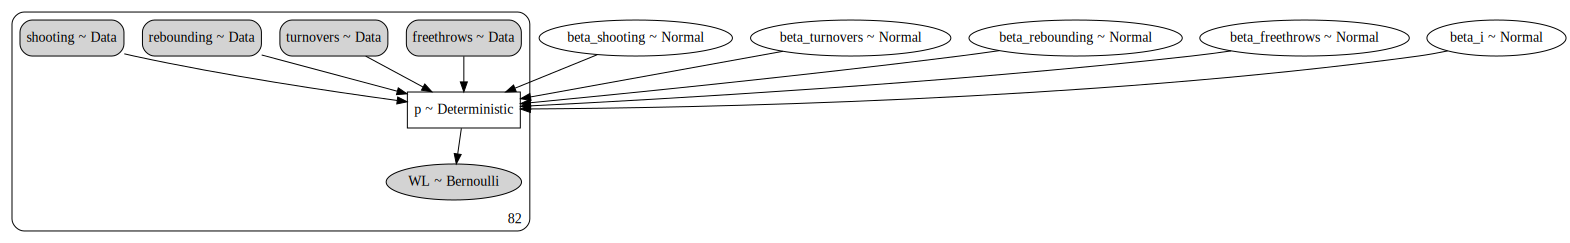

In [140]:
pm.model_to_graphviz(celtics_regression_model)

In [141]:
with celtics_regression_model:
    cdata = pm.sample(1000, tune=2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_freethrows, beta_rebounding, beta_turnovers, beta_shooting, beta_i]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:06<00:00, 437.74it/s]


In [142]:
az.summary(cdata, round_to=3)

d:\Anaconda3.5.1\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_i,0.044,0.552,-0.943,1.042,0.017,0.014,1108.927,817.781,1122.288,1152.540,1.002
beta_shooting,1.337,0.859,-0.205,2.912,0.024,0.017,1270.640,1270.640,1283.733,1099.611,1.002
beta_turnovers,-0.170,0.958,-2.050,1.499,0.021,0.022,2071.420,927.866,2077.350,1409.661,1.000
beta_rebounding,0.524,0.923,-1.216,2.247,0.022,0.019,1752.396,1167.215,1749.688,1287.530,1.001
beta_freethrows,-0.173,0.955,-1.985,1.623,0.022,0.023,1890.255,882.368,1866.573,1468.042,1.001
...,...,...,...,...,...,...,...,...,...,...,...
p[77],0.686,0.061,0.576,0.808,0.001,0.001,1982.421,1982.421,1997.790,1692.446,1.001
p[78],0.673,0.057,0.571,0.782,0.001,0.001,1649.391,1641.964,1639.528,1536.000,0.999
p[79],0.697,0.054,0.603,0.804,0.001,0.001,2159.942,2141.878,2152.711,1498.443,1.000
p[80],0.718,0.056,0.609,0.817,0.001,0.001,2047.929,2047.929,2052.940,1630.213,1.000


40/25/20/15?

Dean-Oliver-assigned offensive factors winning proportion :

- Shooting (40%)
- Turnovers (25%)
- Rebounding (20%)
- Free Throws (15%)

Our sim says:

In [94]:
1.349 / 0.515, 40 / 25

(2.6194174757281554, 1.6)

In [92]:
np.linalg.norm((np.array([1.349, -0.153, 0.515, -0.170]) - np.array([0.4, 0.15, 0.25, 0.20])), axis=0)

1.095232851954323

## 4.7 Conclusion
For the 2022 Celtics, it looks like *good shooting* is relatively more important than rebounding. It's probably because they're a real good shooting team.

Also, turnovers and free throws do not appear to be strongly correlated with winning (in fact, strangely enough, a bit negatively correlated).

d:\Anaconda3.5.1\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


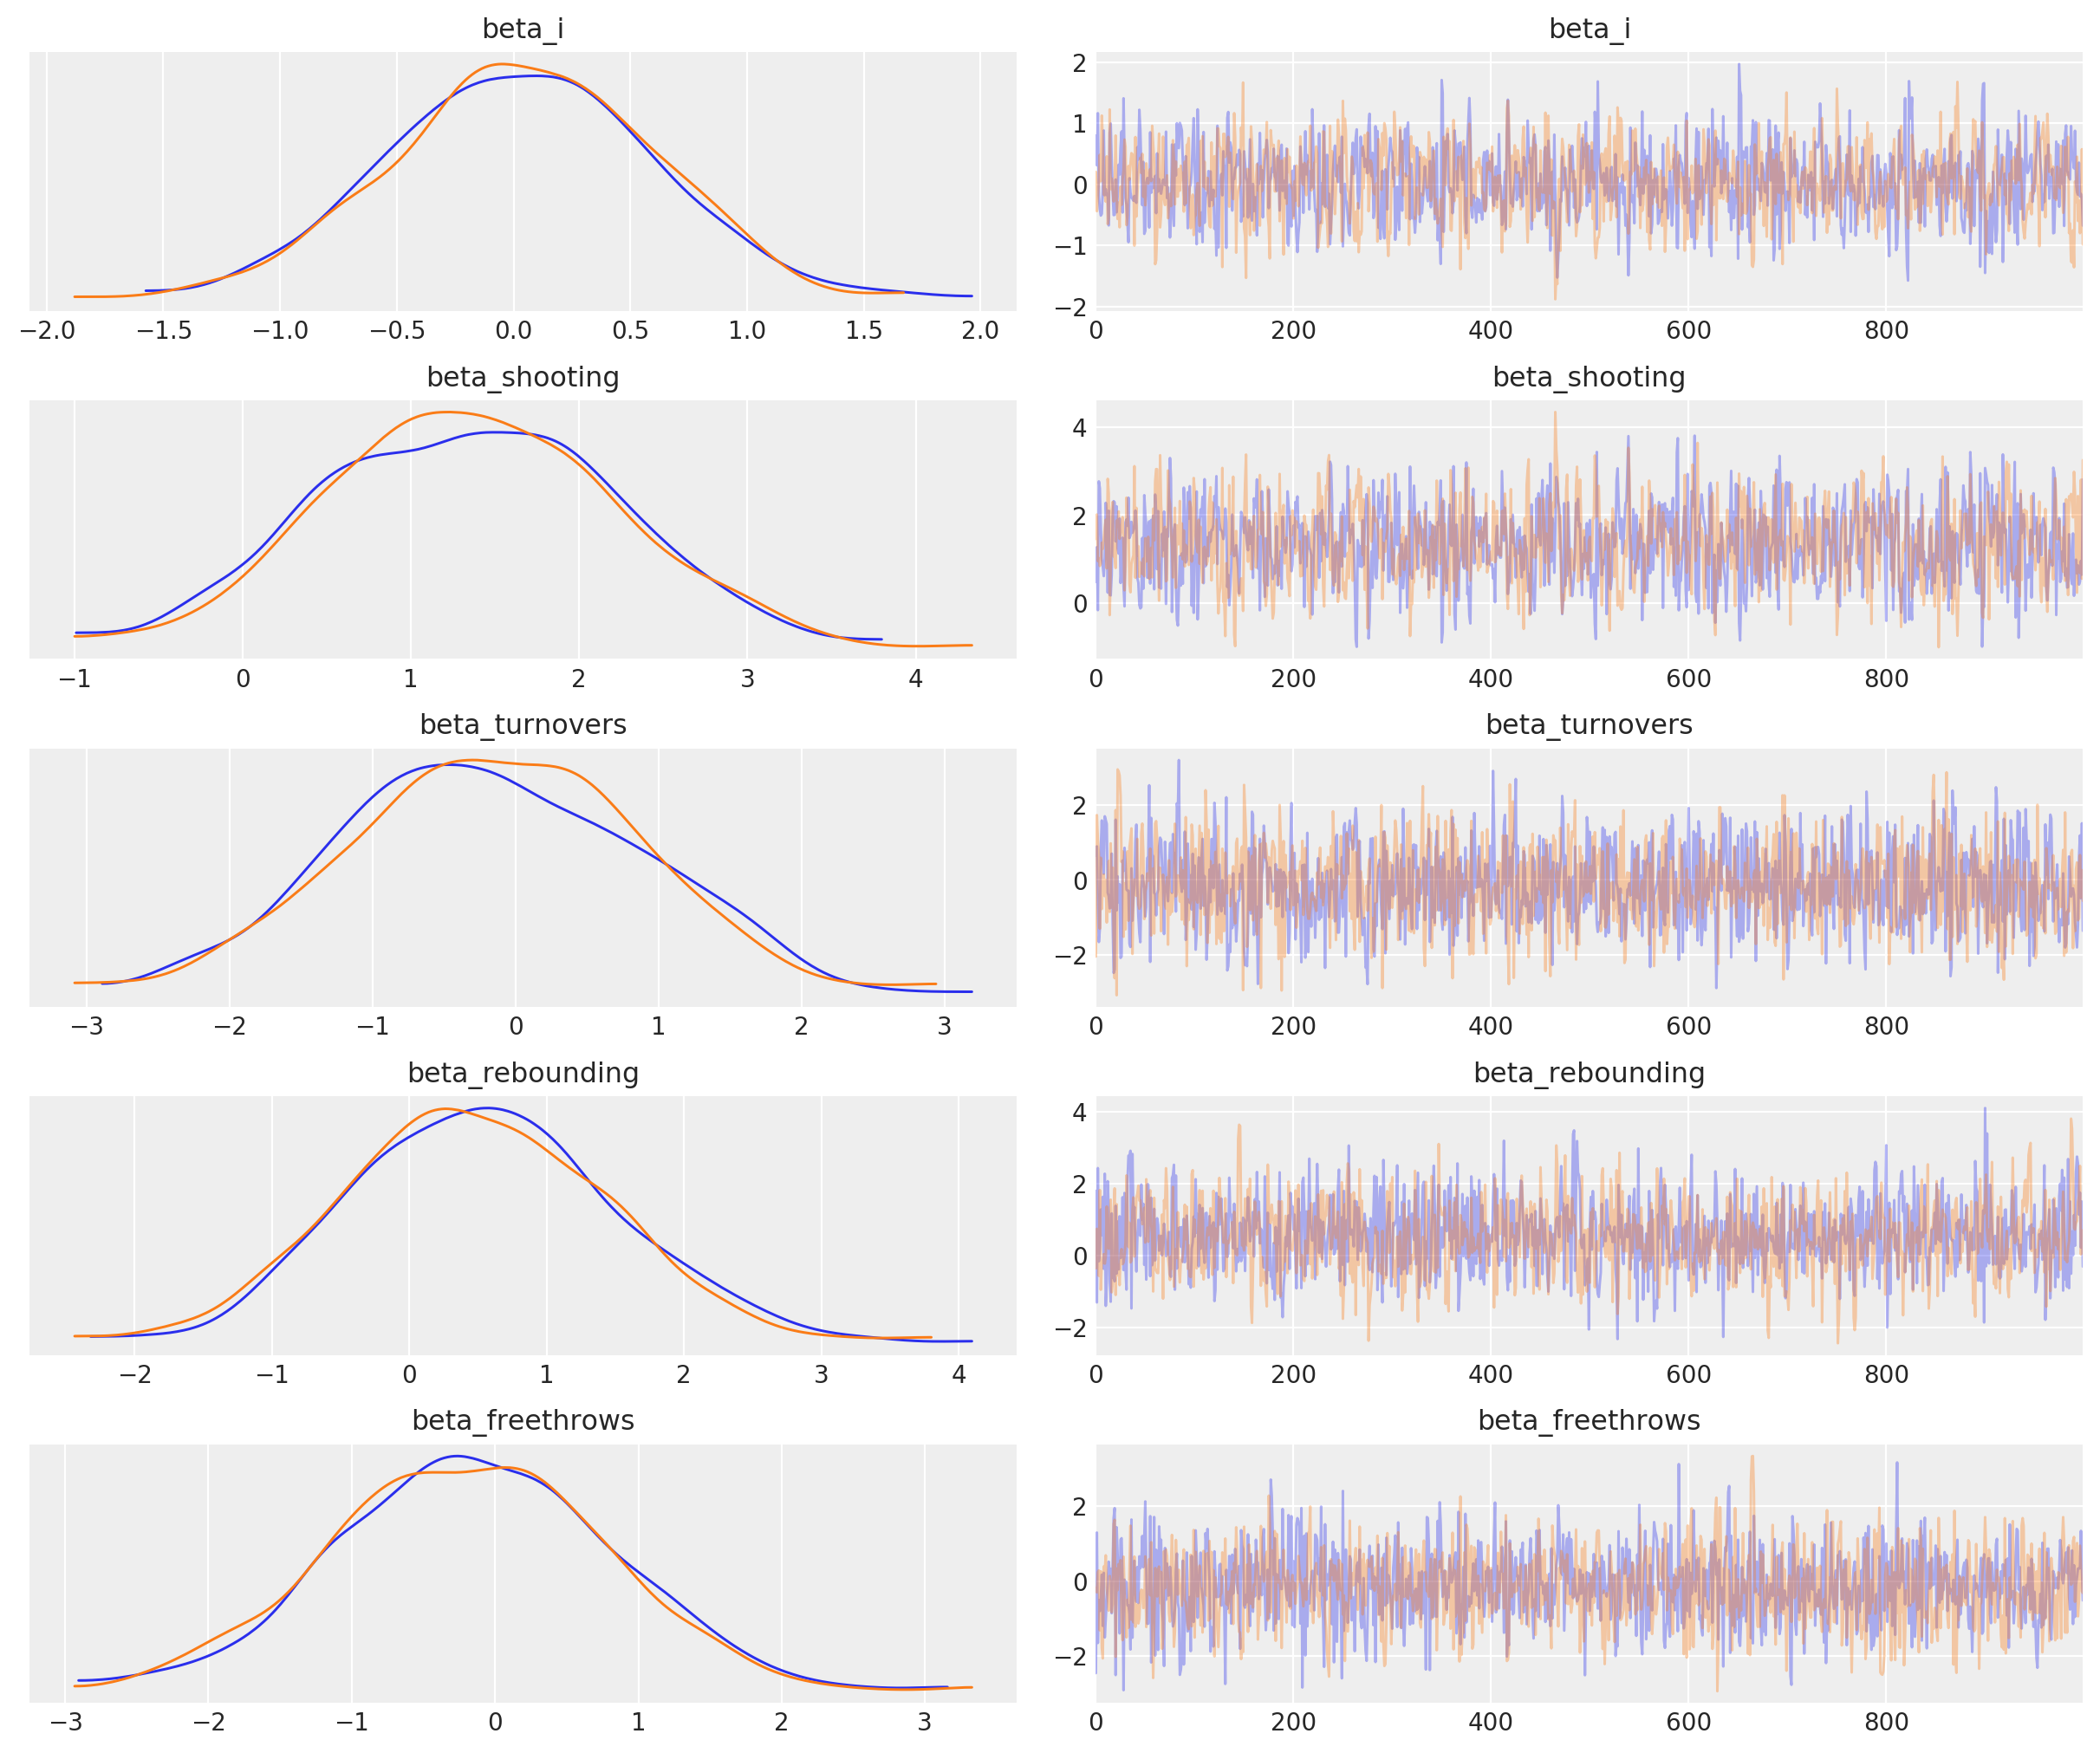

In [77]:
az.plot_trace(cdata, var_names=["beta_i", "beta_shooting", "beta_turnovers", "beta_rebounding", "beta_freethrows"]);

In [78]:
with celtics_regression_model:
    # prior analysis
    prior_pc = pm.sample_prior_predictive()

    # posterior predictive
    ppc = pm.sample_posterior_predictive(trace=cdata,
                                              random_seed=1,
                                              )
    # generate inference data
    lm_idata = az.from_pymc3(
                             trace=cdata,
                             prior=prior_pc,
                             posterior_predictive=ppc,
                             )

100%|██████████| 2000/2000 [00:02<00:00, 943.88it/s] 


Our ability to conduct posterior predictive checks allows us to verify our model. The plot below shows the extent to which our model, after learning from the data, is able to reconstruct what was observed (*unfinished, sorry...*):

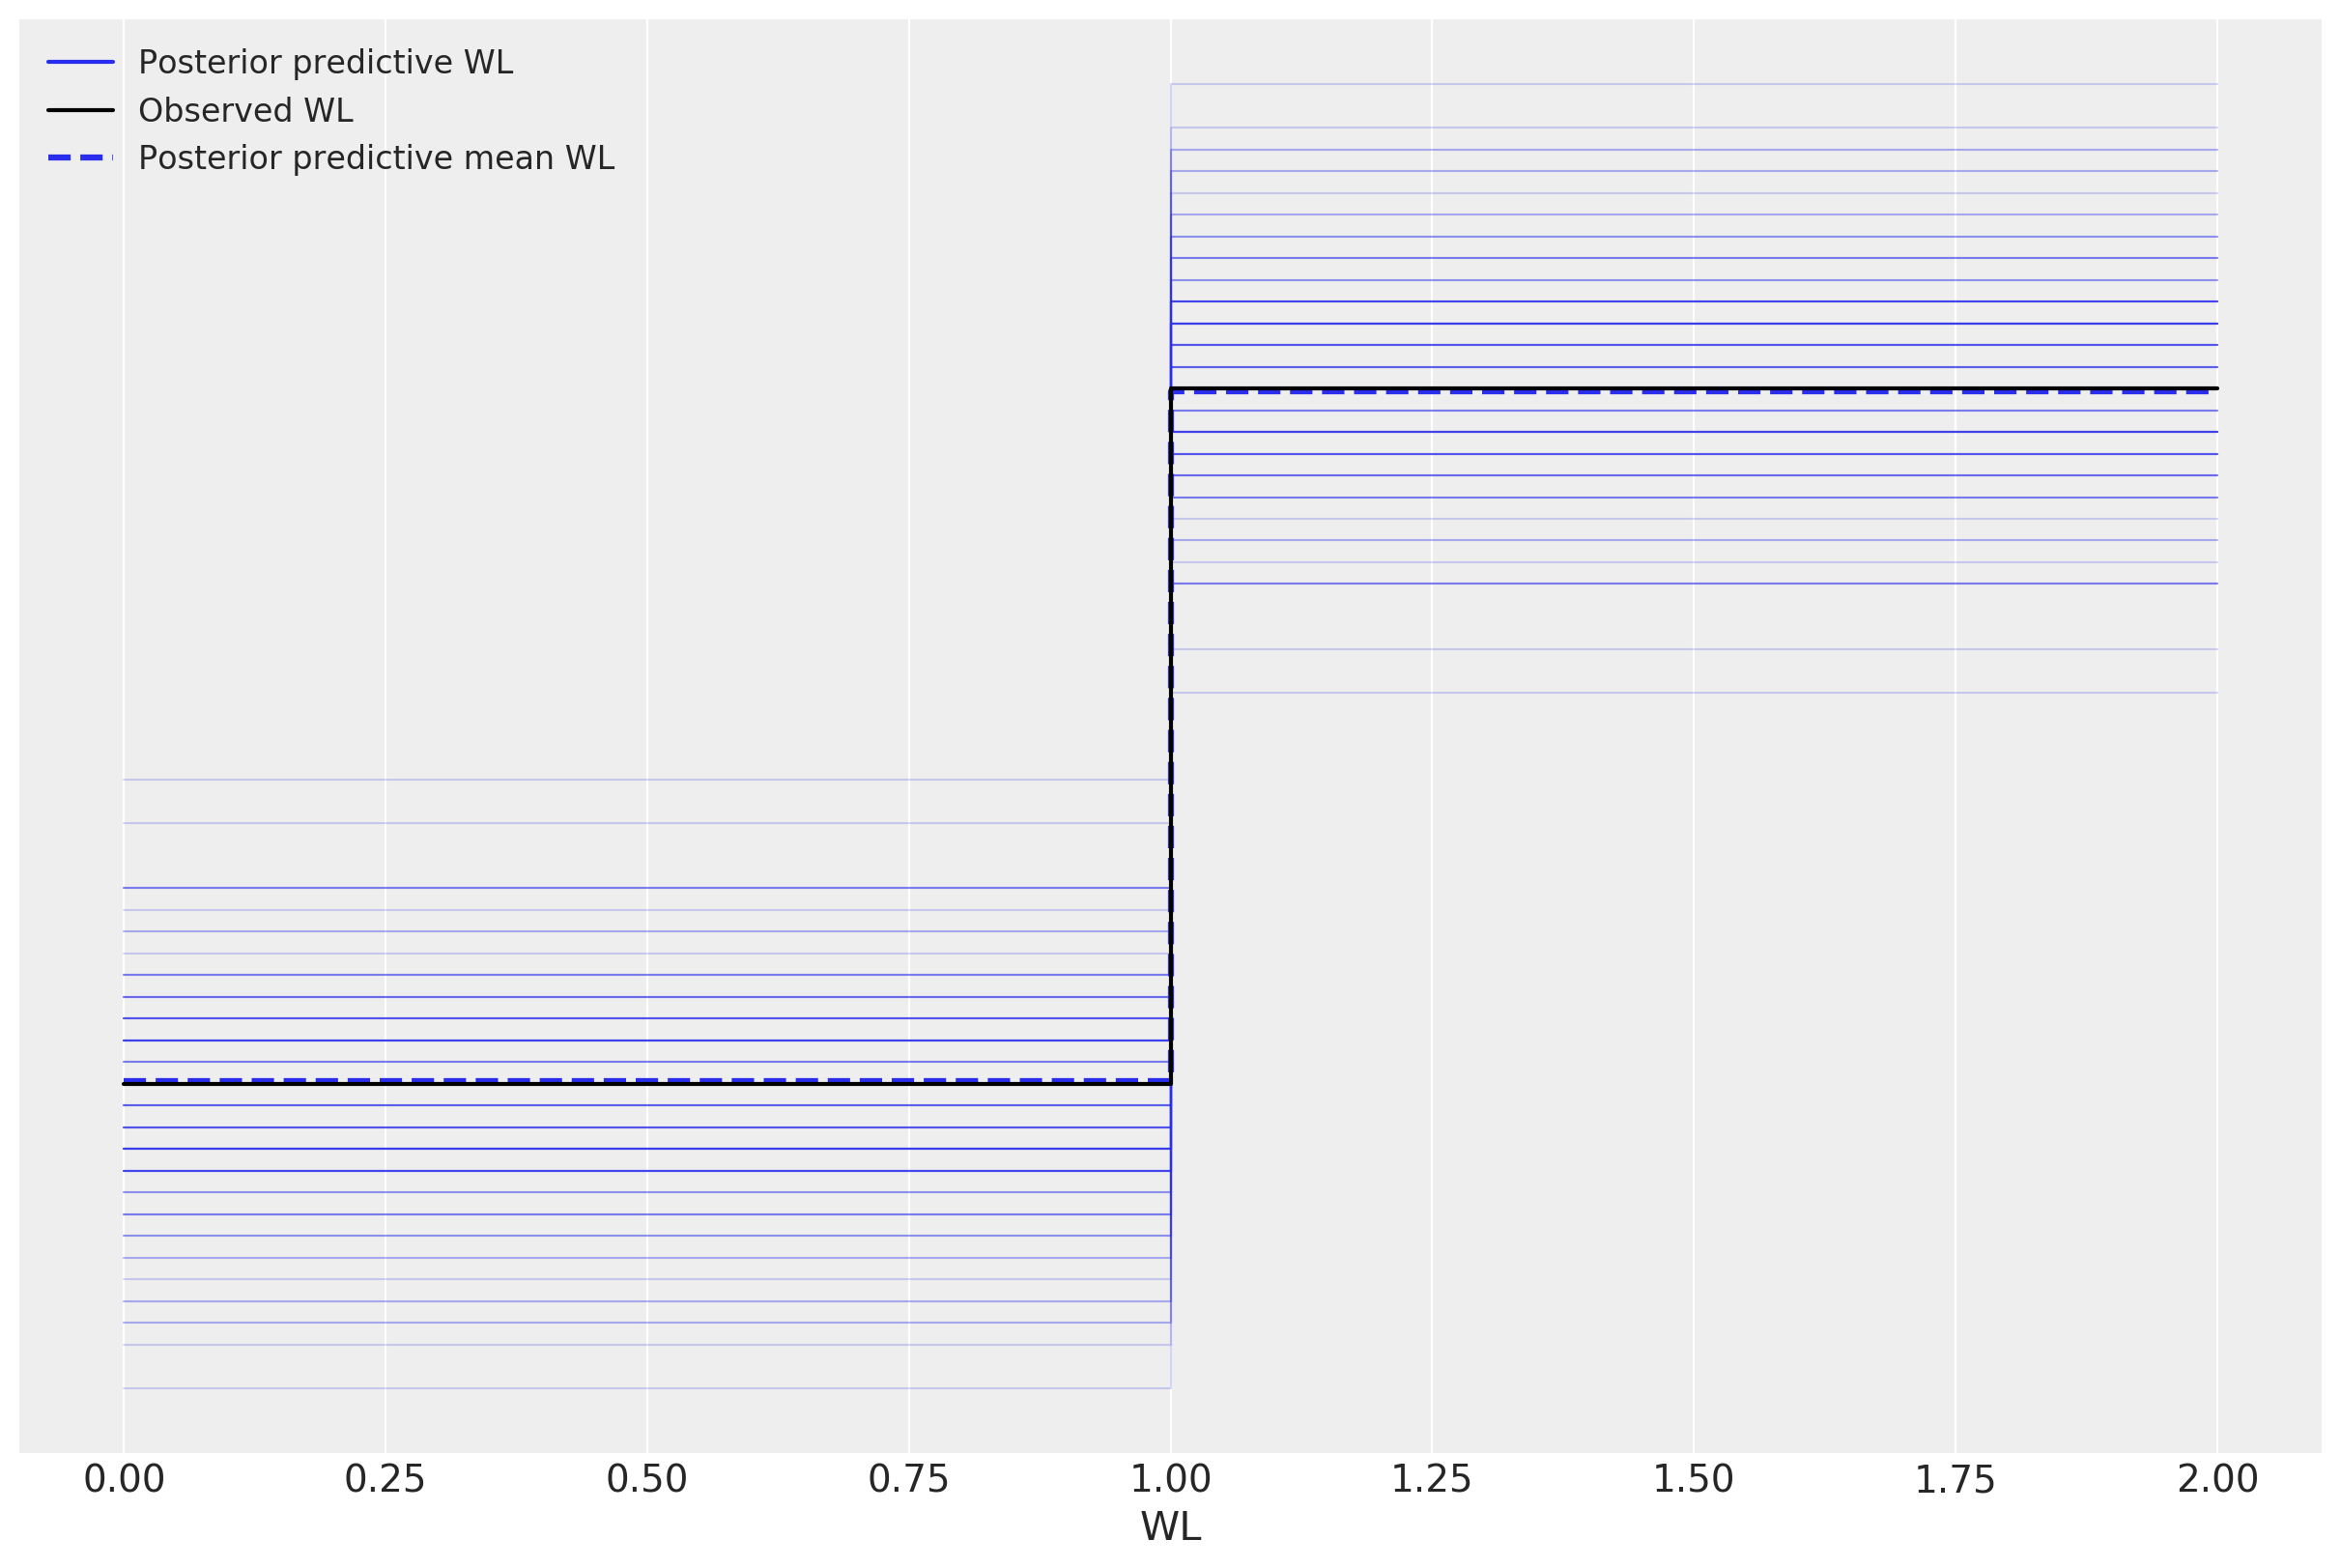

In [79]:
# diagnostics: plot posterior
with celtics_regression_model:
    fig, ax = plt.subplots(figsize=(12,8))
    az.plot_ppc(data=lm_idata, num_pp_samples=100, group='posterior', ax=ax);
    #ax.axvline(np.mean(target), ls="--", color="r", label="True mean")
    ax.legend(fontsize=12);

# 5. Lab Celtics 2024 (so far)
Exciting changes for the Celtics since the 2023 season: They got rid of Marcus Smart and added Porzingis to their lineup.

<br />
<center>
<img src="ipynb.images/celtics23.jpeg" width=1000 />
</center>

>**Lab**: Load either the 2023 or the 2024 season stats, and predict if the Celtics are going to win the crown this season!

In [80]:
#Call the API endpoint passing in Celtics's ID & which season 
gamelog_bos23 = teamgamelog.TeamGameLog(team_id=BOS_id, season = '2022')

#Converts gamelog object into a pandas dataframe
#can also convert to JSON or dictionary  
df_bos_games_2023 = gamelog_bos23.get_data_frames()
df_bos_games_2023

[       Team_ID     Game_ID     GAME_DATE      MATCHUP WL   W   L  W_PCT  MIN  \
 0   1610612738  0022201216  APR 09, 2023  BOS vs. ATL  W  57  25  0.695  240   
 1   1610612738  0022201206  APR 07, 2023  BOS vs. TOR  W  56  25  0.691  240   
 2   1610612738  0022201192  APR 05, 2023  BOS vs. TOR  W  55  25  0.688  240   
 3   1610612738  0022201181  APR 04, 2023    BOS @ PHI  L  54  25  0.684  240   
 4   1610612738  0022201152  MAR 31, 2023  BOS vs. UTA  W  54  24  0.692  240   
 ..         ...         ...           ...          ... ..  ..  ..    ...  ...   
 77  1610612738  0022200072  OCT 28, 2022  BOS vs. CLE  L   3   2  0.600  265   
 78  1610612738  0022200047  OCT 24, 2022    BOS @ CHI  L   3   1  0.750  240   
 79  1610612738  0022200030  OCT 22, 2022    BOS @ ORL  W   3   0  1.000  240   
 80  1610612738  0022200022  OCT 21, 2022    BOS @ MIA  W   2   0  1.000  240   
 81  1610612738  0022200001  OCT 18, 2022  BOS vs. PHI  W   1   0  1.000  240   
 
     FGM  ...  FT_PCT  ORE

In [81]:
with open(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba23-bos-games.pkl', 'wb') as fp:
    pickle.dump(df_bos_games_2023, fp)

In [82]:
df_bos_games_2023[0]['Game_ID'].values

array(['0022201216', '0022201206', '0022201192', '0022201181',
       '0022201152', '0022201146', '0022201130', '0022201116',
       '0022201097', '0022201081', '0022201062', '0022201053',
       '0022201039', '0022201024', '0022201008', '0022200986',
       '0022200971', '0022200969', '0022200948', '0022200935',
       '0022200921', '0022200908', '0022200887', '0022200877',
       '0022200869', '0022200855', '0022200838', '0022200824',
       '0022200808', '0022200788', '0022200772', '0022200749',
       '0022200730', '0022200714', '0022200707', '0022200692',
       '0022200679', '0022200656', '0022200642', '0022200627',
       '0022200621', '0022200606', '0022200591', '0022200577',
       '0022200562', '0022200549', '0022200525', '0022200507',
       '0022200495', '0022200482', '0022200469', '0022200445',
       '0022200430', '0022200413', '0022200408', '0022200392',
       '0022200373', '0022200355', '0022200346', '0022200328',
       '0022200314', '0022200301', '0022200294', '00222

In [83]:
df = BoxScoreFourFactorsV2(game_id='0022201039').get_data_frames()[1]   
df

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT
0,0022201039,1610612750,Timberwolves,MIN,Minnesota,240.000000:00,0.512,0.262,0.132,0.157,0.476,0.357,0.110,0.231
1,0022201039,1610612738,Celtics,BOS,Boston,240.000000:00,0.476,0.357,0.110,0.154,0.512,0.262,0.132,0.255


In [84]:
df2 = BoxScoreFourFactorsV2(game_id='0022201024').get_data_frames()[1]   
df2

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT
0,0022201024,1610612745,Rockets,HOU,Houston,240.000000:00,0.506,0.300,0.112,0.283,0.517,0.241,0.140,0.286
1,0022201024,1610612738,Celtics,BOS,Boston,240.000000:00,0.517,0.241,0.140,0.204,0.506,0.300,0.112,0.340


In [85]:
four_factors_celtics_2023 = df.copy()

for i in df_bos_games_2023[0]['Game_ID'].values[1:]:
    df2 = BoxScoreFourFactorsV2(game_id=i).get_data_frames()[1]
    four_factors_celtics_2023 = pd.concat([four_factors_celtics_2023[four_factors_celtics_2023['TEAM_NAME'] == 'Celtics'], 
                                       df2[df2['TEAM_NAME'] == 'Celtics']],  ignore_index = True)
    time.sleep(1)
    
four_factors_celtics_2023

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT
0,0022201039,1610612738,Celtics,BOS,Boston,240.000000:00,0.476,0.357,0.110,0.154,0.512,0.262,0.132,0.255
1,0022201206,1610612738,Celtics,BOS,Boston,240.000000:00,0.648,0.259,0.214,0.333,0.478,0.183,0.083,0.268
2,0022201192,1610612738,Celtics,BOS,Boston,240.000000:00,0.489,0.202,0.149,0.200,0.444,0.189,0.124,0.273
3,0022201181,1610612738,Celtics,BOS,Boston,240.000000:00,0.500,0.176,0.086,0.232,0.571,0.205,0.132,0.225
4,0022201152,1610612738,Celtics,BOS,Boston,240.000000:00,0.526,0.229,0.111,0.182,0.526,0.146,0.168,0.314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0022200072,1610612738,Celtics,BOS,Boston,265.000000:00,0.591,0.390,0.173,0.114,0.609,0.391,0.147,0.239
78,0022200047,1610612738,Celtics,BOS,Boston,240.000000:00,0.460,0.120,0.108,0.219,0.540,0.333,0.140,0.304
79,0022200030,1610612738,Celtics,BOS,Boston,240.000000:00,0.592,0.322,0.080,0.149,0.553,0.242,0.088,0.321
80,0022200022,1610612738,Celtics,BOS,Boston,240.000000:00,0.608,0.190,0.214,0.316,0.500,0.163,0.102,0.314


In [86]:
four_factors_celtics_2023_v2 = four_factors_celtics_2023.copy()
four_factors_celtics_2023_v2['PTS'] = df_bos_games_2023[0]['PTS']
four_factors_celtics_2023_v2['WL'] = df_bos_games_2023[0]['WL'].apply(lambda x:0 if x == "L" else 1)
four_factors_celtics_2023_v2

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PTS,WL
0,0022201039,1610612738,Celtics,BOS,Boston,240.000000:00,0.476,0.357,0.110,0.154,0.512,0.262,0.132,0.255,120,1
1,0022201206,1610612738,Celtics,BOS,Boston,240.000000:00,0.648,0.259,0.214,0.333,0.478,0.183,0.083,0.268,121,1
2,0022201192,1610612738,Celtics,BOS,Boston,240.000000:00,0.489,0.202,0.149,0.200,0.444,0.189,0.124,0.273,97,1
3,0022201181,1610612738,Celtics,BOS,Boston,240.000000:00,0.500,0.176,0.086,0.232,0.571,0.205,0.132,0.225,101,0
4,0022201152,1610612738,Celtics,BOS,Boston,240.000000:00,0.526,0.229,0.111,0.182,0.526,0.146,0.168,0.314,122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0022200072,1610612738,Celtics,BOS,Boston,265.000000:00,0.591,0.390,0.173,0.114,0.609,0.391,0.147,0.239,123,0
78,0022200047,1610612738,Celtics,BOS,Boston,240.000000:00,0.460,0.120,0.108,0.219,0.540,0.333,0.140,0.304,102,0
79,0022200030,1610612738,Celtics,BOS,Boston,240.000000:00,0.592,0.322,0.080,0.149,0.553,0.242,0.088,0.321,126,1
80,0022200022,1610612738,Celtics,BOS,Boston,240.000000:00,0.608,0.190,0.214,0.316,0.500,0.163,0.102,0.314,111,1


In [87]:
with open(r'D:\user\docs\NU\_Info6105\Lecture 5 (bayesian-labs)\data\nba23-4factors-celtics.pkl', 'wb') as fp:
    pickle.dump(four_factors_celtics_2023_v2, fp)

In [88]:
with pm.Model() as celtics_regression_model_23:
    shooting = pm.Data("shooting", four_factors_celtics_2023_v2["EFG_PCT"])
    turnovers = pm.Data("turnovers", four_factors_celtics_2023_v2["TM_TOV_PCT"])
    rebounding = pm.Data("rebounding", four_factors_celtics_2023_v2["OREB_PCT"])
    freethrows = pm.Data("freethrows", four_factors_celtics_2023_v2["FTA_RATE"])
    
    # priors
    beta_i = pm.Normal("beta_i", mu=0, sd=1)
    beta_shooting = pm.Normal("beta_shooting", mu=0, sd=1)
    beta_turnovers = pm.Normal("beta_turnovers", mu=0, sd=1)
    beta_rebounding = pm.Normal("beta_rebounding", mu=0, sd=1)
    beta_freethrows = pm.Normal("beta_freethrows", mu=0, sd=1)
    
    # linear model
    mu = beta_i + beta_shooting * shooting + beta_turnovers * turnovers + beta_rebounding * rebounding + beta_freethrows * freethrows
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    
    # likelihood
    pm.Bernoulli("WL", p=p, observed=four_factors_celtics_2023_v2["WL"])

In [89]:
with celtics_regression_model_23:
    cdata23 = pm.sample(1000, tune=2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_freethrows, beta_rebounding, beta_turnovers, beta_shooting, beta_i]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:07<00:00, 407.46it/s]


In [90]:
az.summary(cdata23, round_to=3)

d:\Anaconda3.5.1\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_i,0.056,0.575,-1.143,1.027,0.018,0.014,1014.277,874.047,1014.845,951.442,1.001
beta_shooting,1.313,0.867,-0.274,2.933,0.025,0.018,1161.092,1138.651,1160.772,1197.912,1.001
beta_turnovers,-0.184,1.012,-2.092,1.598,0.023,0.023,1937.942,1007.923,1942.200,1448.196,1.000
beta_rebounding,0.510,0.978,-1.261,2.339,0.023,0.021,1803.118,1083.268,1814.726,1441.415,1.001
beta_freethrows,-0.174,0.953,-1.948,1.630,0.022,0.022,1953.005,955.449,1940.858,1350.827,1.001
...,...,...,...,...,...,...,...,...,...,...,...
p[77],0.684,0.063,0.562,0.799,0.001,0.001,2100.557,2100.557,2131.646,1574.773,1.002
p[78],0.672,0.057,0.573,0.786,0.001,0.001,1559.985,1559.985,1569.110,1439.542,1.001
p[79],0.695,0.055,0.595,0.796,0.001,0.001,2041.669,2041.669,2052.380,1406.980,1.001
p[80],0.716,0.058,0.610,0.821,0.001,0.001,2089.325,2089.325,2130.959,1391.692,1.000


In [95]:
1.313 / 0.510, 0.4 / 0.25

(2.5745098039215684, 1.6)

In [96]:
np.linalg.norm((np.array([1.313, -0.184, 0.510, -0.174]) - np.array([0.4, 0.15, 0.25, 0.20])), axis=0)

1.0735925670383526

<br />
<center>
<img src="ipynb.images/gambling-hacker.webp" width=1000 />
</center>